# Setup Datasets

## Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from itertools import combinations
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf # Create a GLM model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Import PCA for visualization
#!pip install tensorflow keras
import tensorflow as tf
from tensorflow import keras
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



## Load Datasets

In [ ]:
def load_dataset_from_github(api_directory_url):
    """
    Given a GitHub API URL pointing to a repository directory, fetches all CSV files
    in that directory and returns a dictionary mapping filenames to pandas DataFrames.

    Parameters:
    -----------
    api_directory_url : str
        GitHub API URL for a repository directory, e.g.
        "https://api.github.com/repos/username/repo/contents/path/to/dir"

    Returns:
    --------
    dict[str, pandas.DataFrame]
        A dictionary where each key is a CSV filename (e.g., "data.csv")
        and each value is the corresponding DataFrame obtained from reading
        the file's raw URL.
    array of dataframes
    """
    response = requests.get(api_directory_url)
    response.raise_for_status()  # Raise an error if request failed
    files = response.json()

    dataframes = {}
    for file in files:
        name = file.get("name", "")
        if name.endswith(".csv"):
            raw_url = file.get("download_url")
            if raw_url:
                dataframes[name] = pd.read_csv(raw_url)
    ordered_names = [
        '1-mental-illnesses-prevalence.csv',
        '2-burden-disease-from-each-mental-illness.csv',
        '3-adult-population-covered-in-primary-data-on-the-prevalence-of-major-depression.csv',
        '4-adult-population-covered-in-primary-data-on-the-prevalence-of-mental-illnesses.csv',
        '5-anxiety-disorders-treatment-gap.csv',
        '6-depressive-symptoms-across-us-population.csv',
        '7-number-of-countries-with-primary-data-on-prevalence-of-mental-illnesses-in-the-global-burden-of-disease-study.csv',
        'GDP.csv'
    ]
    dfs = [dataframes[name] for name in ordered_names]

    return dataframes, dfs

## Utility Functions

In [9]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_rel
import numpy as np
import matplotlib.pyplot as plt

# Global store
model_results = []
reference_residuals = None  # Set externally for p-value comparison

def bootstrap_r2(y_true, y_pred, n_bootstrap=1000, alpha=0.05):
    """
    Bootstrap confidence intervals for R² score.
    """
    n = len(y_true)
    r2_scores = []
    rng = np.random.default_rng(seed=42)
    for _ in range(n_bootstrap):
        indices = rng.integers(0, n, size=n)
        r2_scores.append(r2_score(y_true[indices], y_pred[indices]))
    lower = np.percentile(r2_scores, 100 * alpha / 2)
    upper = np.percentile(r2_scores, 100 * (1 - alpha / 2))
    return (lower, upper)

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, store_results=True, plot=True):
    """
    Evaluate a regression model on training and test data, compute metrics, and optionally plot results.
    """
    global reference_residuals

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Ensure predictions are 1D arrays if the model outputs 2D (like Neural Networks)
    if hasattr(y_train_pred, 'flatten'):
        y_train_pred = y_train_pred.flatten()
    if hasattr(y_test_pred, 'flatten'):
        y_test_pred = y_test_pred.flatten()

    # Ensure y_test is a NumPy array for consistent operations
    y_test_np = np.array(y_test)
    y_train_np = np.array(y_train)

    # Compute metrics
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)

    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Bootstrap CI
    r2_test_ci = bootstrap_r2(np.array(y_test), np.array(y_test_pred))

    # Paired t-test vs reference model (if available)
    residuals = np.array(y_test) - np.array(y_test_pred)
    if reference_residuals is not None:
        _, p_value = ttest_rel(reference_residuals, residuals)
    else:
        p_value = None
        reference_residuals = residuals  # first model becomes reference

    print(f"\n{model_name} Evaluation:")
    print(f"Train R²: {r2_train:.4f}, Test R²: {r2_test:.4f} (95% CI: {r2_test_ci[0]:.4f}, {r2_test_ci[1]:.4f})")
    print(f"Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f}")
    if p_value is not None:
        print(f"p-value vs reference model: {p_value:.4f}")

    if store_results:
        model_results.append({
            'model': model_name,
            'r2_train': r2_train,
            'r2_test': r2_test,
            'r2_test_ci_lower': r2_test_ci[0],
            'r2_test_ci_upper': r2_test_ci[1],
            'mse_train': mse_train,
            'mse_test': mse_test,
            'p_value_vs_ref': p_value
        })

    if plot:
        plt.figure(figsize=(8, 8))
        plt.scatter(y_test, y_test_pred, alpha=0.6, label='Predicted vs Actual')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal Fit')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'{model_name} - Actual vs Predicted')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'r2_train': r2_train,
        'r2_test': r2_test,
        'r2_test_ci': r2_test_ci,
        'mse_train': mse_train,
        'mse_test': mse_test,
        'p_value_vs_ref': p_value
    }

def box_plots(df_skip):
    """
    Draw boxplots for each column in the DataFrame to visualize outliers.
    """
    for column in df_skip:
        print(f"Boxplot for Column Name: {column}")
        #draw boxplot and kde before analyte to visualize the outliers
        fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 2))
        plt.subplots_adjust(wspace=1, hspace=0.25)
        axes[0].set_title(f'Boxplot | Mean: {df_skip[column].mean():.3f}', fontsize=8)
        sns.boxplot(y=df_skip[column], ax=axes[0])

        #handle outliers using IQR
        Q1 = df_skip[column].quantile(0.25)
        Q3 = df_skip[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_iqr = df_skip[[column]].copy()
        df_iqr[column]= df_skip[column].clip(lower=lower_bound, upper=upper_bound)

        #draw boxplot after handling outliers
        axes[1].set_title(f'Boxplot after IQR | Mean: {df_iqr[column].mean():.3f}', fontsize=8)
        sns.boxplot(y=df_iqr[column], ax=axes[1], color='orange')

        # Try z-score method to compare results with IQR method
        df_z = df_skip[[column]].copy()
        df_z['z_score'] = zscore(df_z[column])
        df_z['capped'] = df_z[column].where(df_z['z_score'].abs() <= 3) #created capped column to cap values smaller or equal to z-score 3 which is 99.7%

        axes[2].set_title(f'After Z-Score | Mean: {df_z[column].mean():.3f}', fontsize=8)
        sns.boxplot(y=df_z['capped'].dropna(), ax=axes[2], color='green')

        plt.show()

def find_strong_relation(corr_matrix, cov_matrix):
    """
    Find pairs of variables with strong correlation and their covariance.
    """
    strong_corr_pairs = []
    # Find pairs of variables with strong correlation (|corr| >= 0.5) and their covariance
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = corr_matrix.loc[col1, col2]
            if abs(corr_val) >= 0.5:
                cov_val = cov_matrix.loc[col1, col2]
                strong_corr_pairs.append((col1, col2, corr_val, cov_val))
    result_df = pd.DataFrame(strong_corr_pairs, columns=['Variable 1', 'Variable 2', 'Correlation', 'Covariance'])

    return result_df

def linear_regression_plot(df, col_x, col_y):
    """
    Perform linear regression on two columns of a DataFrame and plot the results.
    """
    X = df[[col_x]]
    y = df[col_y]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)

    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, alpha=0.6, label='Data Points')
    plt.plot(X, y_pred, color='red', label='Regression Line')
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(f'{col_x} vs {col_y} | Regression: {r2:.2f} | MSE: {mse:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Clean Datasets

In [10]:
# Load CSV files
file_path = "https://api.github.com/repos/AAI500TeamProject/thementalists-project/contents/Dataset/MentalHealth"
dataframes, dfs = load_dataset_from_github(file_path)

[           Entity Code  Year  \
0     Afghanistan  AFG  1990   
1     Afghanistan  AFG  1991   
2     Afghanistan  AFG  1992   
3     Afghanistan  AFG  1993   
4     Afghanistan  AFG  1994   
...           ...  ...   ...   
6415     Zimbabwe  ZWE  2015   
6416     Zimbabwe  ZWE  2016   
6417     Zimbabwe  ZWE  2017   
6418     Zimbabwe  ZWE  2018   
6419     Zimbabwe  ZWE  2019   

      Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized  \
0                                              0.223206                                   
1                                              0.222454                                   
2                                              0.221751                                   
3                                              0.220987                                   
4                                              0.220183                                   
...                                                 ...             

In [11]:
# Drop columns
for name, df in dataframes.items():
     if name != 'GDP.csv':
          df.drop(columns ='Code', inplace=True)

          #Rename the lengthy columns to make the table compactpact=
          df.rename(columns = {
          'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'Schizophrenia Disorders',
               'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depression Disorders',
               'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized': 'Anxiety Disorders',
               'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized': 'Bipolar Disorders',
               'Eating disorders (share of population) - Sex: Both - Age: Age-standardized' : 'Eating Disorders'
     }, inplace = True)

          df.rename(columns={
               'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders': 'Depression Disorders',
               'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia': 'Schizophrenia Disorders',
               'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Bipolar disorder': 'Bipolar Disorder',
               'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Eating disorders': 'Eating Disorders',
               'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Anxiety disorders': 'Anxiety Disorders'
     }, inplace=True)

          df.rename(columns={
               'Potentially adequate treatment, conditional': 'Adequate_Treatment',
               'Other treatments, conditional': 'Other_Treatments',
               'Untreated, conditional': 'Untreated'
     }, inplace=True)

          df.rename(columns={
               'Nearly every day': 'Severe_Symptoms',
               'More than half the days': 'Moderate_Symptoms',
               'Several days': 'Mild_Symptoms',
               'Not at all': 'No_Symptoms'
     }, inplace=True)


          df.rename(columns={
               'Number of countries with primary data on prevalence of mental disorders': 'Countries_With_Data'
     }, inplace=True)

          # standardizing column names
          df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

          # Trim whitespace in string columns
          for col in df.select_dtypes(include='object'):
               df[col] = df[col].str.strip()

          # Convert data types where appropriate
          if 'year' in df.columns:
               df['year'] = pd.to_numeric(df['year'], errors='coerce', downcast='integer')

# Check for and handle missing values
for i, df in enumerate(dfs):
    print(f"\nMissing values in DataFrame {i}:")
    print(df.isnull().sum())

# Preview each DataFrame
for i, df in enumerate(dfs):
    print(f"\nDataFrame {i} Preview:")
    print(df.head())


Missing values in DataFrame 0:
entity                     0
year                       0
schizophrenia_disorders    0
depression_disorders       0
anxiety_disorders          0
bipolar_disorders          0
eating_disorders           0
dtype: int64

Missing values in DataFrame 1:
entity                     0
year                       0
depression_disorders       0
schizophrenia_disorders    0
bipolar_disorder           0
eating_disorders           0
anxiety_disorders          0
dtype: int64

Missing values in DataFrame 2:
entity              0
year                0
major_depression    0
dtype: int64

Missing values in DataFrame 3:
entity               0
year                 0
major_depression     0
bipolar_disorder     0
eating_disorders     0
dysthymia            0
schizophrenia        0
anxiety_disorders    0
dtype: int64

Missing values in DataFrame 4:
entity                0
year                  0
adequate_treatment    0
other_treatments      0
untreated             0
dtype: int64

In [12]:
for i, df in enumerate(dfs, start=5):
    print(f"{'='*60}")
    print(f"📊 DataFrame {i} Summary")
    print(f"{'='*60}")

    # Show basic info
    print(f"Shape: {df.shape}")
    print(f"\nColumns:\n{list(df.columns)}")

    # Show missing values neatly
    print(f"\nMissing Values:\n{df.isnull().sum()[df.isnull().sum() > 0].to_string()}")

    # Show preview
    print("\nPreview (first 5 rows):")
    display(df.head())  # Jupyter-friendly display

📊 DataFrame 5 Summary
Shape: (6420, 7)

Columns:
['entity', 'year', 'schizophrenia_disorders', 'depression_disorders', 'anxiety_disorders', 'bipolar_disorders', 'eating_disorders']

Missing Values:
Series([], )

Preview (first 5 rows):


entity  year  schizophrenia_disorders  depression_disorders  \
0  Afghanistan  1990                 0.223206              4.996118   
1  Afghanistan  1991                 0.222454              4.989290   
2  Afghanistan  1992                 0.221751              4.981346   
3  Afghanistan  1993                 0.220987              4.976958   
4  Afghanistan  1994                 0.220183              4.977782   

   anxiety_disorders  bipolar_disorders  eating_disorders  
0           4.713314           0.703023          0.127700  
1           4.702100           0.702069          0.123256  
2           4.683743           0.700792          0.118844  
3           4.673549           0.700087          0.115089  
4           4.670810           0.699898          0.111815

📊 DataFrame 6 Summary
Shape: (6840, 7)

Columns:
['entity', 'year', 'depression_disorders', 'schizophrenia_disorders', 'bipolar_disorder', 'eating_disorders', 'anxiety_disorders']

Missing Values:
Series([], )

Preview (first 5 rows):


entity  year  depression_disorders  schizophrenia_disorders  \
0  Afghanistan  1990             895.22565                138.24825   
1  Afghanistan  1991             893.88434                137.76122   
2  Afghanistan  1992             892.34973                137.08030   
3  Afghanistan  1993             891.51587                136.48602   
4  Afghanistan  1994             891.39160                136.18323   

   bipolar_disorder  eating_disorders  anxiety_disorders  
0         147.64412         26.471115          440.33000  
1         147.56696         25.548681          439.47202  
2         147.13086         24.637949          437.60718  
3         146.78812         23.863169          436.69104  
4         146.58481         23.189074          436.76800

📊 DataFrame 7 Summary
Shape: (22, 3)

Columns:
['entity', 'year', 'major_depression']

Missing Values:
Series([], )

Preview (first 5 rows):


entity  year  major_depression
0  Andean Latin America  2008               0.0
1          Asia Pacific  2008              80.8
2           Australasia  2008             100.0
3             Caribbean  2008               9.1
4          Central Asia  2008               0.0

📊 DataFrame 8 Summary
Shape: (22, 8)

Columns:
['entity', 'year', 'major_depression', 'bipolar_disorder', 'eating_disorders', 'dysthymia', 'schizophrenia', 'anxiety_disorders']

Missing Values:
Series([], )

Preview (first 5 rows):


entity  year  major_depression  bipolar_disorder  \
0  Andean Latin America  2008               0.0               0.0   
1          Asia Pacific  2008              80.8               3.8   
2           Australasia  2008             100.0             100.0   
3             Caribbean  2008               9.1               0.0   
4          Central Asia  2008               0.0               0.0   

   eating_disorders  dysthymia schizophrenia  anxiety_disorders  
0               0.0        0.0             0                0.0  
1              23.1        1.0          71.6               93.1  
2              16.4      100.0          85.1              100.0  
3               0.0        0.0          28.3                0.0  
4               0.0        0.0             0                0.0

📊 DataFrame 9 Summary
Shape: (26, 5)

Columns:
['entity', 'year', 'adequate_treatment', 'other_treatments', 'untreated']

Missing Values:
Series([], )

Preview (first 5 rows):


entity  year  adequate_treatment  other_treatments  \
0                Argentina  2015                12.0              18.0   
1  Beijing/Shanghai, China  2005                 8.8               8.5   
2                  Belgium  2002                11.2              24.5   
3                 Bulgaria  2006                 7.3              14.3   
4                 Colombia  2012                 3.2              10.0   

   untreated  
0       70.0  
1       82.7  
2       64.3  
3       78.4  
4       86.8

📊 DataFrame 10 Summary
Shape: (10, 6)

Columns:
['entity', 'year', 'severe_symptoms', 'moderate_symptoms', 'mild_symptoms', 'no_symptoms']

Missing Values:
Series([], )

Preview (first 5 rows):


entity  year  severe_symptoms  moderate_symptoms  \
0           Appetite change  2014              4.6                5.1   
1   Average across symptoms  2014              4.4                4.3   
2            Depressed mood  2014              3.6                3.9   
3  Difficulty concentrating  2014              3.5                3.6   
4          Loss of interest  2014              4.4                5.4   

   mild_symptoms  no_symptoms  
0           15.5         74.8  
1           15.0         76.3  
2           16.8         75.7  
3           10.9         82.1  
4           16.3         73.8

📊 DataFrame 11 Summary
Shape: (15, 3)

Columns:
['entity', 'year', 'countries_with_data']

Missing Values:
Series([], )

Preview (first 5 rows):


entity  year  countries_with_data
0                     Alcohol use disorders  2019                   58
1                 Amphetamine use disorders  2019                   58
2                          Anorexia nervosa  2019                   27
3                         Anxiety disorders  2019                   58
4  Attention-deficit hyperactivity disorder  2019                  172

📊 DataFrame 12 Summary
Shape: (266, 69)

Columns:
['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']

Missing Values:
1960    266
1961    266
1962    266
1963    266
1964    266
1965    266
1966    266
1967    266
1968    266
1969    266
1970    266
1971    266
1972    266
1973    266
1974    266
1975    266
1976    266
1977    266
1978    266
1979    266
1980    266
1981    266
1982    266
1983    266
1984    266
1985    266
1986    266
1987    266
1988    

Country Name Country Code              Indicator Name  \
0                        Aruba          ABW  UHC service coverage index   
1  Africa Eastern and Southern          AFE  UHC service coverage index   
2                  Afghanistan          AFG  UHC service coverage index   
3   Africa Western and Central          AFW  UHC service coverage index   
4                       Angola          AGO  UHC service coverage index   

      Indicator Code  1960  1961  1962  1963  1964  1965  ...  2015  2016  \
0  SH.UHC.SRVS.CV.XD   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
1  SH.UHC.SRVS.CV.XD   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
2  SH.UHC.SRVS.CV.XD   NaN   NaN   NaN   NaN   NaN   NaN  ...  36.0   NaN   
3  SH.UHC.SRVS.CV.XD   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   
4  SH.UHC.SRVS.CV.XD   NaN   NaN   NaN   NaN   NaN   NaN  ...  36.0   NaN   

   2017  2018  2019  2020  2021  2022  2023  2024  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2  41.0   NaN  42.0   NaN  41.0   NaN   NaN   NaN  
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4  40.0   NaN  39.0   NaN  37.0   NaN   NaN   NaN  

[5 rows x 69 columns]

### Scale Dataset #1

In [13]:
# Use the first DataFrame from the list of dataframes 'dfs'
cleaned_df = dfs[0].select_dtypes(include='number').drop(columns=['year'], errors='ignore').dropna()
df1 = cleaned_df;

features = ['schizophrenia_disorders', 'depression_disorders','anxiety_disorders','bipolar_disorders']
X_model = df1[features]
target = 'eating_disorders'
y_model = df1[target]

print("X_model head:")
print(X_model.head())
print("\ny_model head:")
print(y_model.head())

scaler = preprocessing.MinMaxScaler()
X_model_norm = scaler.fit_transform(X_model)

# Convert the normalized array back to a DataFrame with original column names
X_model_norm_df = pd.DataFrame(X_model_norm, columns=X_model.columns, index=X_model.index)

print("\nNormalized X_model head:")
print(X_model_norm_df.head())


X_model head:
   schizophrenia_disorders  depression_disorders  anxiety_disorders  \
0                 0.223206              4.996118           4.713314   
1                 0.222454              4.989290           4.702100   
2                 0.221751              4.981346           4.683743   
3                 0.220987              4.976958           4.673549   
4                 0.220183              4.977782           4.670810   

   bipolar_disorders  
0           0.703023  
1           0.702069  
2           0.700792  
3           0.700087  
4           0.699898  

y_model head:
0    0.127700
1    0.123256
2    0.118844
3    0.115089
4    0.111815
Name: eating_disorders, dtype: float64

Normalized X_model head:
   schizophrenia_disorders  depression_disorders  anxiety_disorders  \
0                 0.127142              0.567281           0.420084   
1                 0.124394              0.566166           0.418422   
2                 0.121826              0.564869          

### Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_model_norm, y_model, test_size=0.20, random_state=42)

print("\nX_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5136, 4)
X_test shape: (1284, 4)
y_train shape: (5136,)
y_test shape: (1284,)


### Create Eating Disorder Label Column

In [15]:
eating_disorders_data = dfs[0]['eating_disorders']
low_risk_threshold = eating_disorders_data.quantile(0.33) # Example: bottom 33% is low
medium_risk_threshold = eating_disorders_data.quantile(0.66) # Example: middle 33% is medium, top 33% is high

def categorize_eating_disorder_risk(prevalence):
    if prevalence <= low_risk_threshold:
        return 'low_risk'
    elif prevalence <= medium_risk_threshold:
        return 'medium_risk'
    else:
        return 'high_risk'
df_eating_disorder_risk = dfs[0].copy()
df_eating_disorder_risk['eating_disorder_risk'] = eating_disorders_data.apply(categorize_eating_disorder_risk)
df_eating_disorder_risk

entity  year  schizophrenia_disorders  depression_disorders  \
0     Afghanistan  1990                 0.223206              4.996118   
1     Afghanistan  1991                 0.222454              4.989290   
2     Afghanistan  1992                 0.221751              4.981346   
3     Afghanistan  1993                 0.220987              4.976958   
4     Afghanistan  1994                 0.220183              4.977782   
...           ...   ...                      ...                   ...   
6415     Zimbabwe  2015                 0.201042              3.407624   
6416     Zimbabwe  2016                 0.201319              3.410755   
6417     Zimbabwe  2017                 0.201639              3.411965   
6418     Zimbabwe  2018                 0.201976              3.406929   
6419     Zimbabwe  2019                 0.202482              3.395476   

      anxiety_disorders  bipolar_disorders  eating_disorders  \
0              4.713314           0.703023          0.127700   
1              4.702100           0.702069          0.123256   
2              4.683743           0.700792          0.118844   
3              4.673549           0.700087          0.115089   
4              4.670810           0.699898          0.111815   
...                 ...                ...               ...   
6415           3.184012           0.538596          0.095652   
6416           3.187148           0.538593          0.096662   
6417           3.188418           0.538589          0.097330   
6418           3.172111           0.538585          0.097909   
6419           3.137017           0.538580          0.098295   

     eating_disorder_risk  
0             medium_risk  
1             medium_risk  
2             medium_risk  
3             medium_risk  
4             medium_risk  
...                   ...  
6415             low_risk  
6416             low_risk  
6417             low_risk  
6418             low_risk  
6419             low_risk  

[6420 rows x 8 columns]

## Box Plots for Mental Illnesses Prevalence                              

#### Dataset 1 Analysis: mental-illnesses-prevalence

Boxplot for Column Name: schizophrenia_disorders


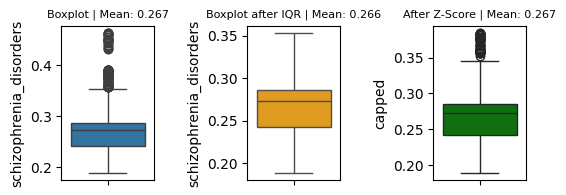

Boxplot for Column Name: depression_disorders


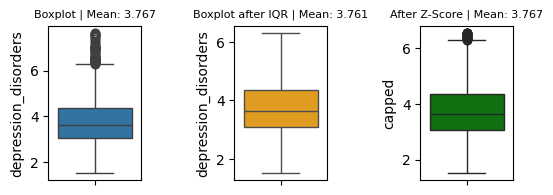

Boxplot for Column Name: anxiety_disorders


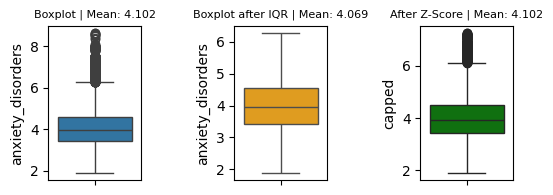

Boxplot for Column Name: bipolar_disorders


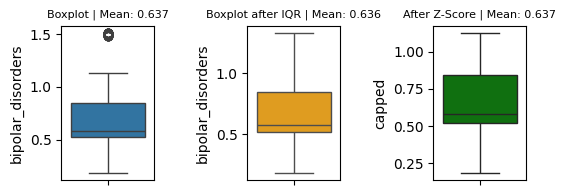

Boxplot for Column Name: eating_disorders


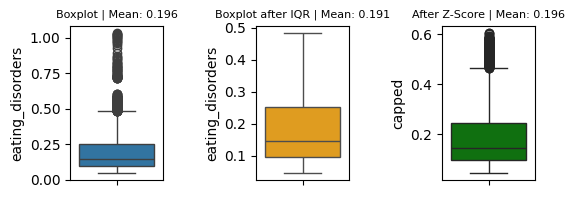

In [16]:
df_skip = dataframes['1-mental-illnesses-prevalence.csv'].iloc[:, 2:]
df_skip = df_skip.apply(pd.to_numeric, errors='coerce')
box_plots(df_skip)

#### Dataset 2 Analysis: burden-disease-from-each-mental-illness

Boxplot for Column Name: depression_disorders


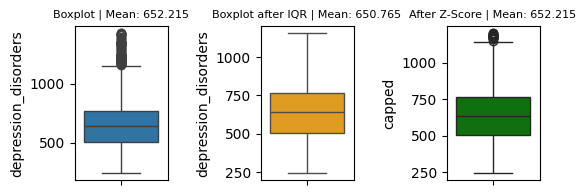

Boxplot for Column Name: schizophrenia_disorders


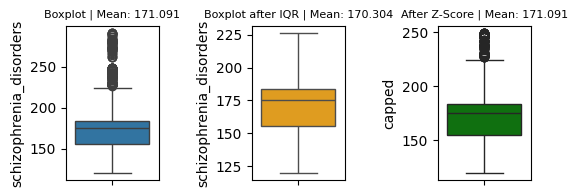

Boxplot for Column Name: bipolar_disorder


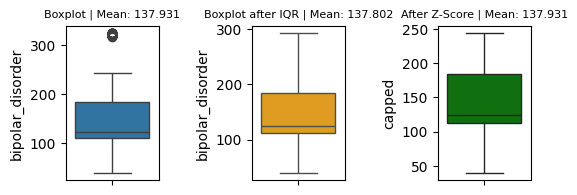

Boxplot for Column Name: eating_disorders


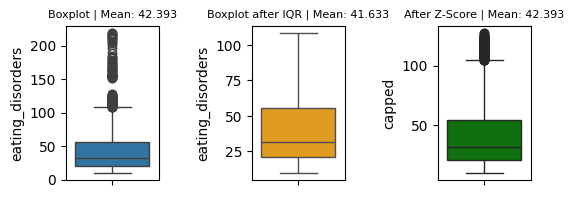

Boxplot for Column Name: anxiety_disorders


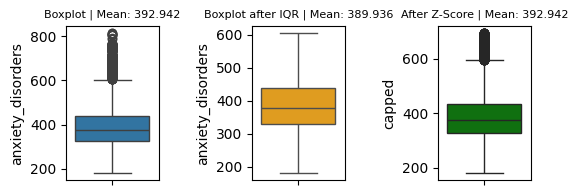

In [17]:
df_skip2 = dataframes['2-burden-disease-from-each-mental-illness.csv'].iloc[:, 2:]
df_skip2 = df_skip2.apply(pd.to_numeric, errors='coerce')
box_plots(df_skip2)

We decided not to remove outliers from the dataset for the following reasons:

In most cases, the outliers did not significantly affect the mean, indicating a relatively stable central tendency.

While some variables showed a noticeable shift in the mean, the outliers still represent valid, real-world observations rather than data entry errors.

These rare but extreme values could carry important information, especially in the context of mental health prevalence, and may be valuable for model learning, anomaly detection, or identifying high-risk populations.

Removing them could lead to a loss of meaningful patterns and potentially limit the model’s generalizability to edge cases.

Therefore, we chose to retain the outliers to preserve the full data distribution and ensure the model captures both common and exceptional conditions.

# Exploratory Data Analysis

## Histogram

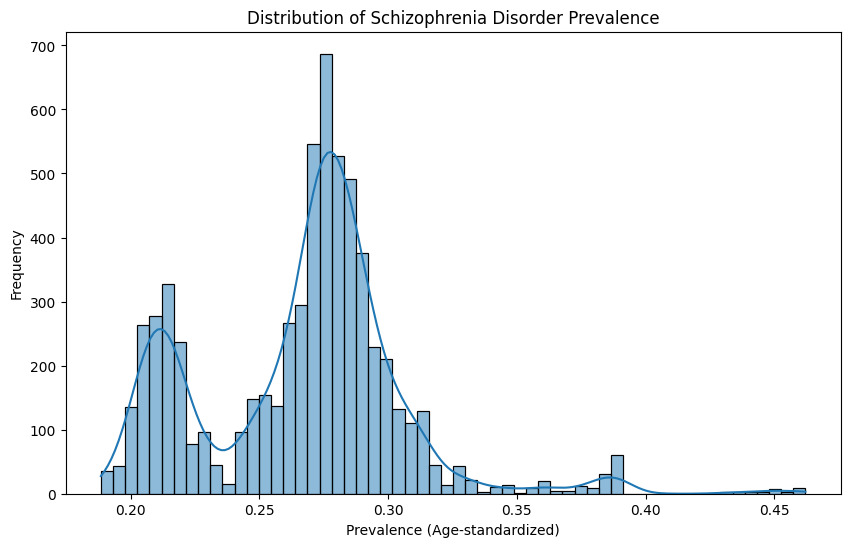

In [18]:
# Example histogram for a targeted variable
# Below this cell will be histograms for all
plt.figure(figsize=(10, 6))
sns.histplot(dfs[0]['schizophrenia_disorders'], kde=True)
plt.title('Distribution of Schizophrenia Disorder Prevalence')
plt.xlabel('Prevalence (Age-standardized)')
plt.ylabel('Frequency')
plt.show()


Plotting histograms for DataFrame 0


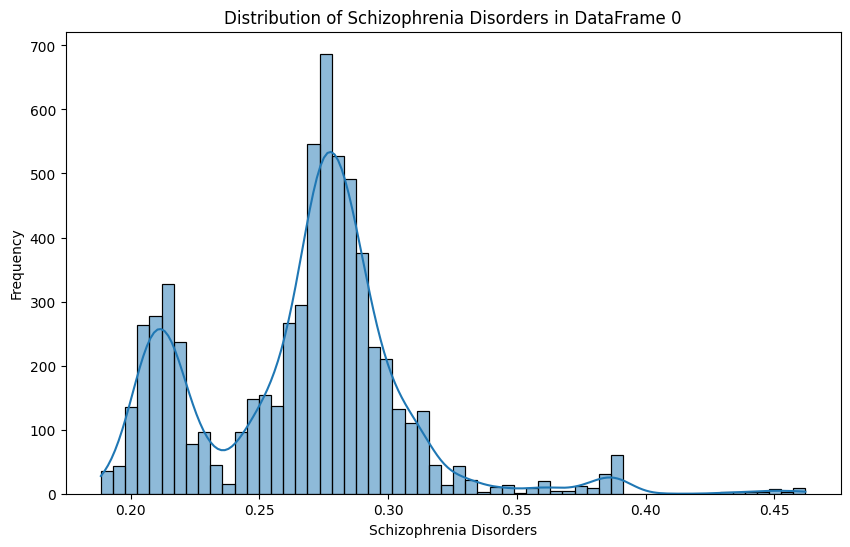

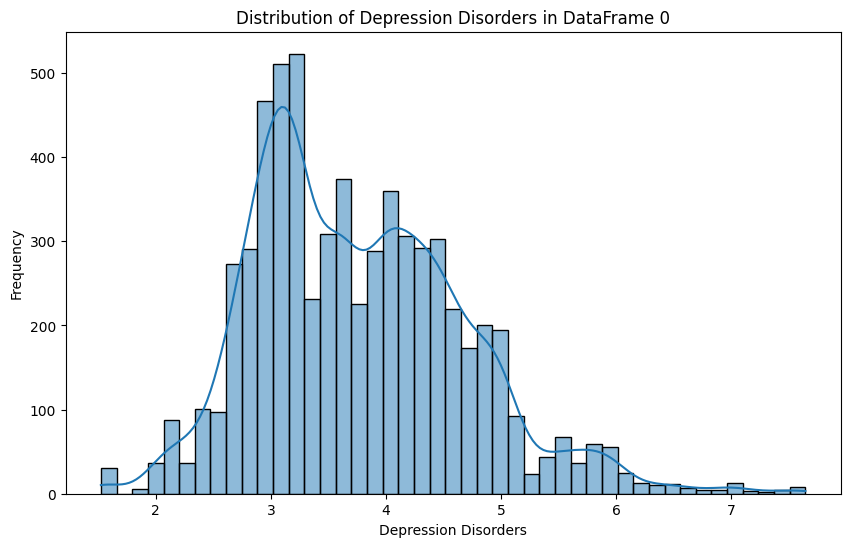

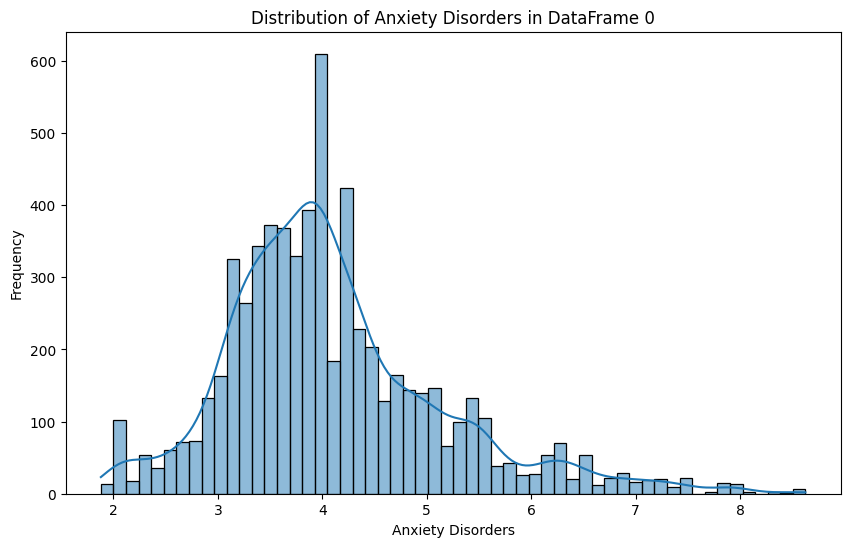

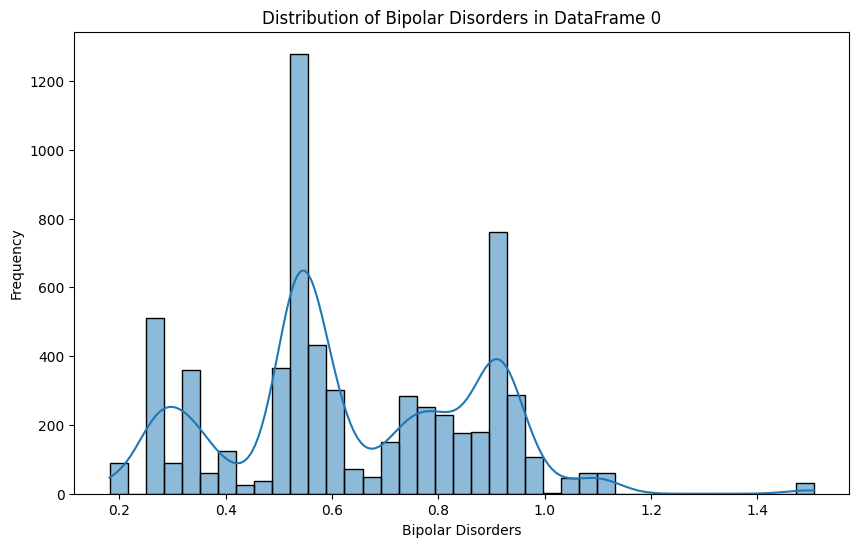

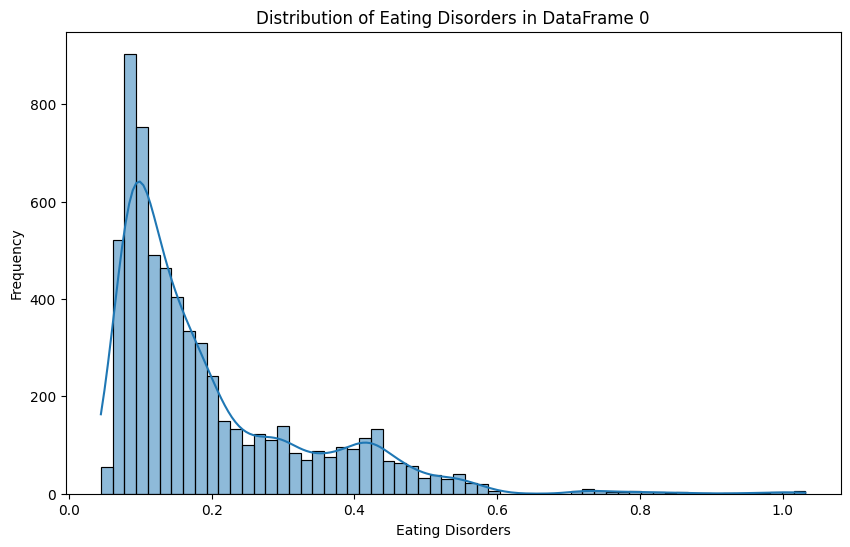


Plotting histograms for DataFrame 1


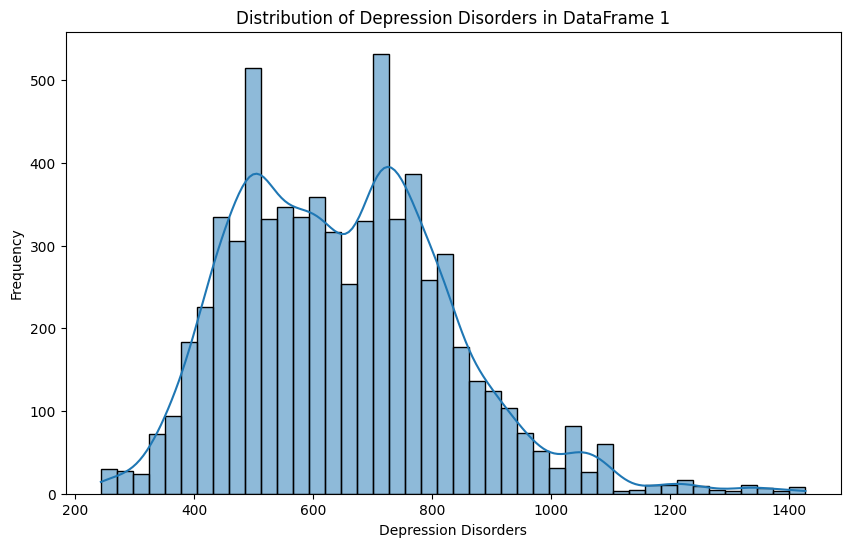

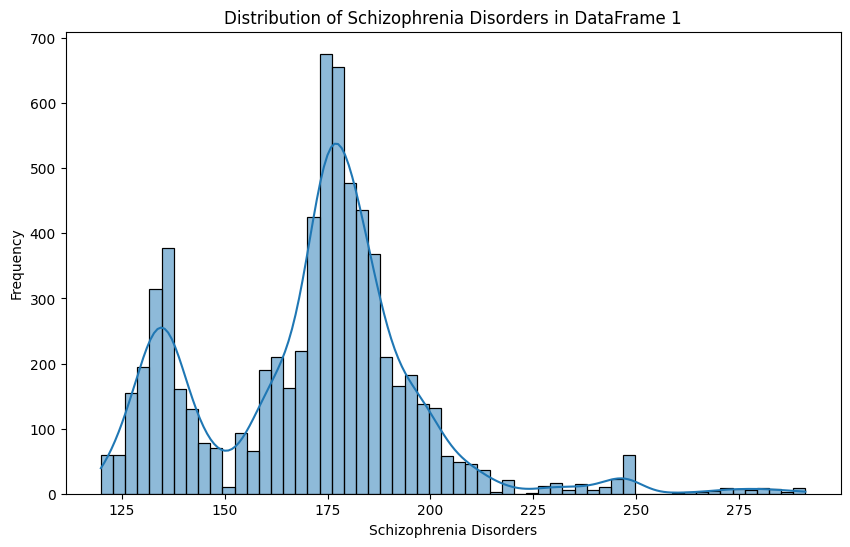

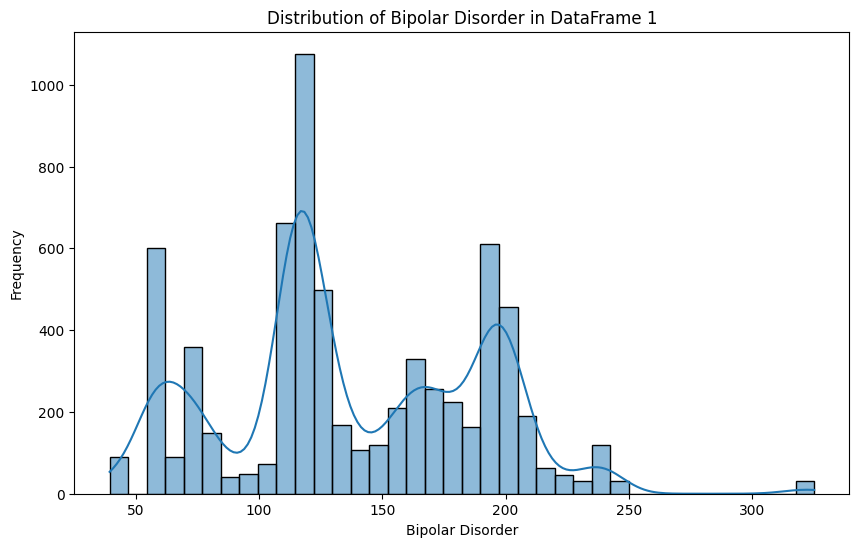

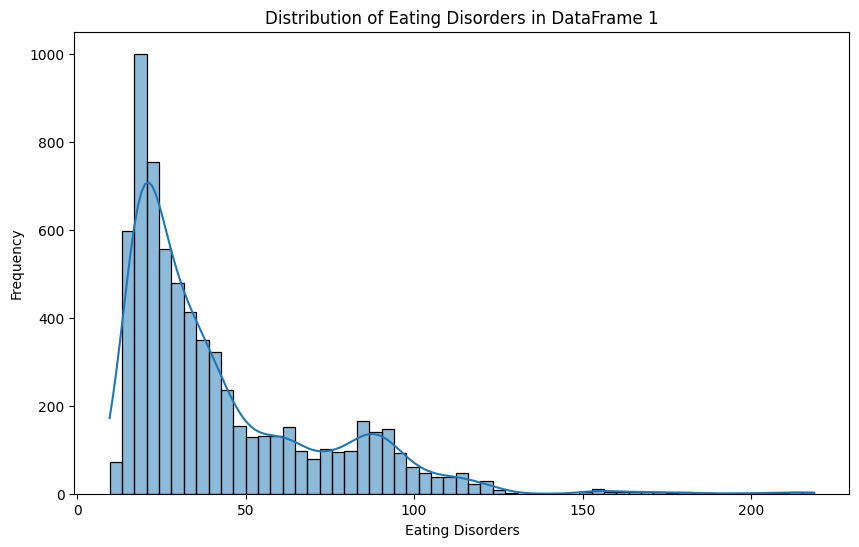

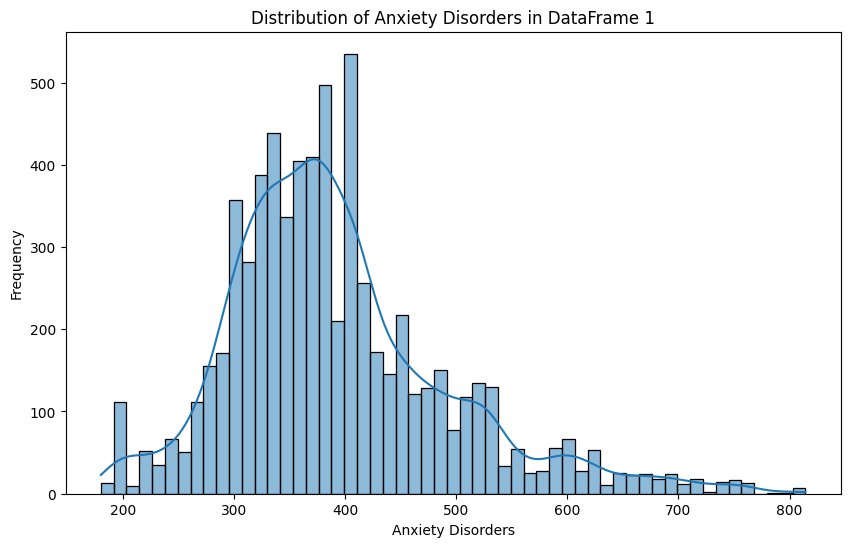


Plotting histograms for DataFrame 2


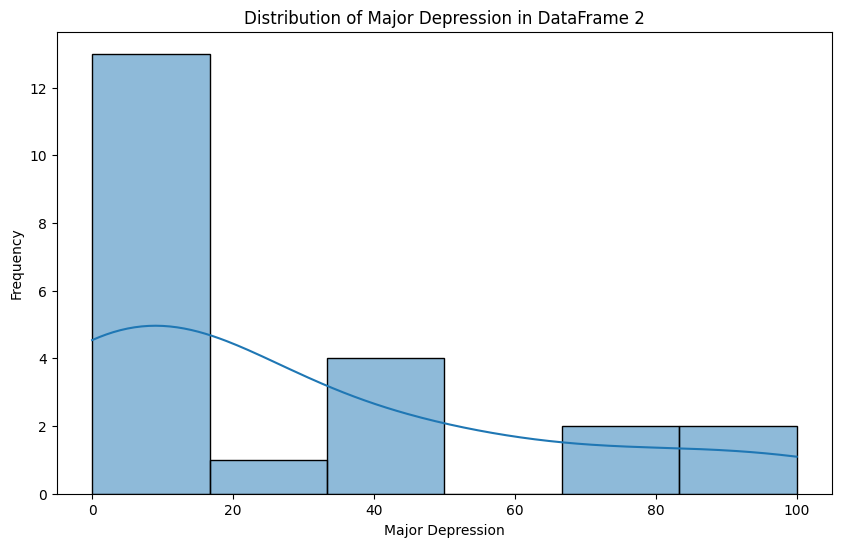


Plotting histograms for DataFrame 3


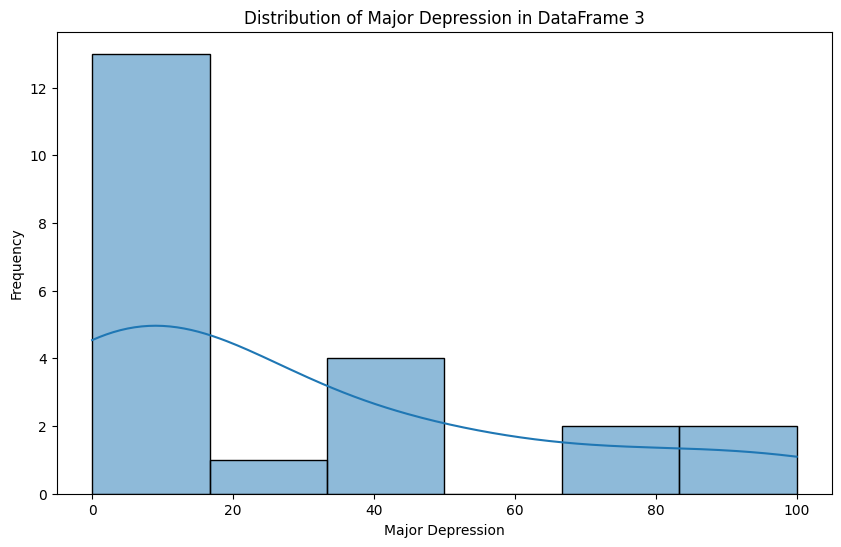

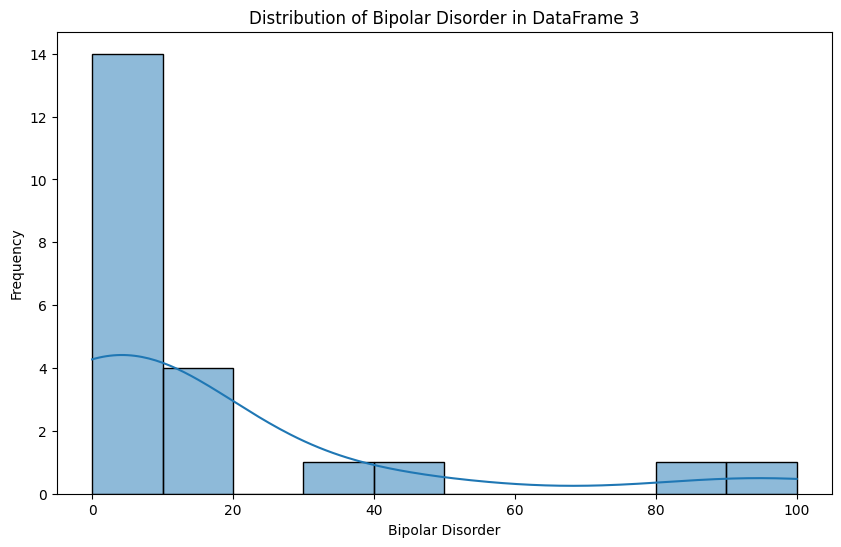

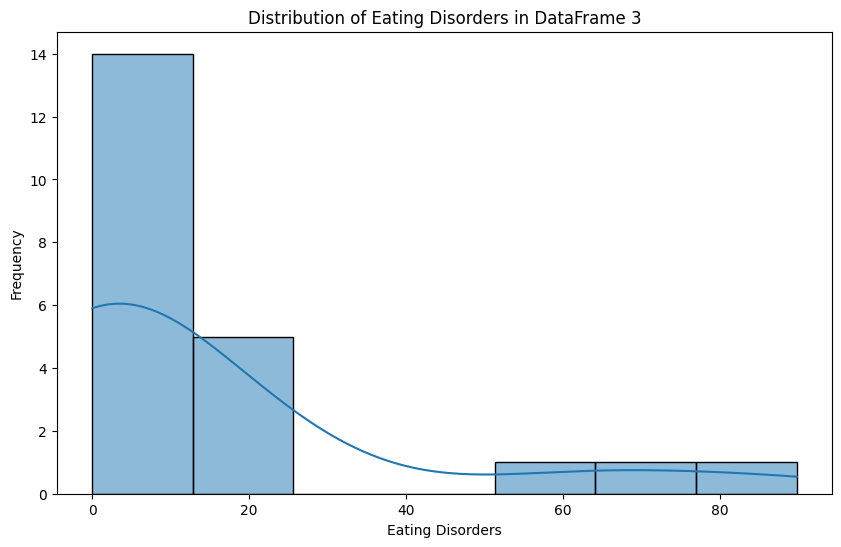

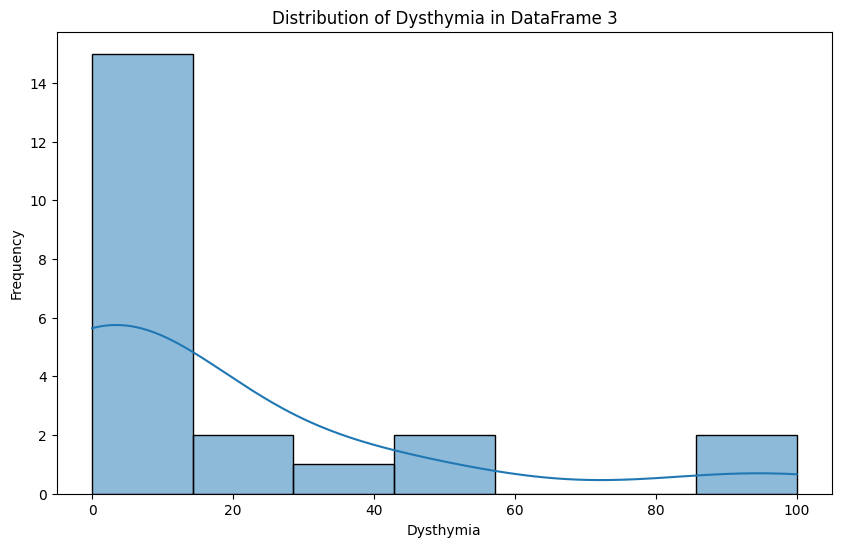

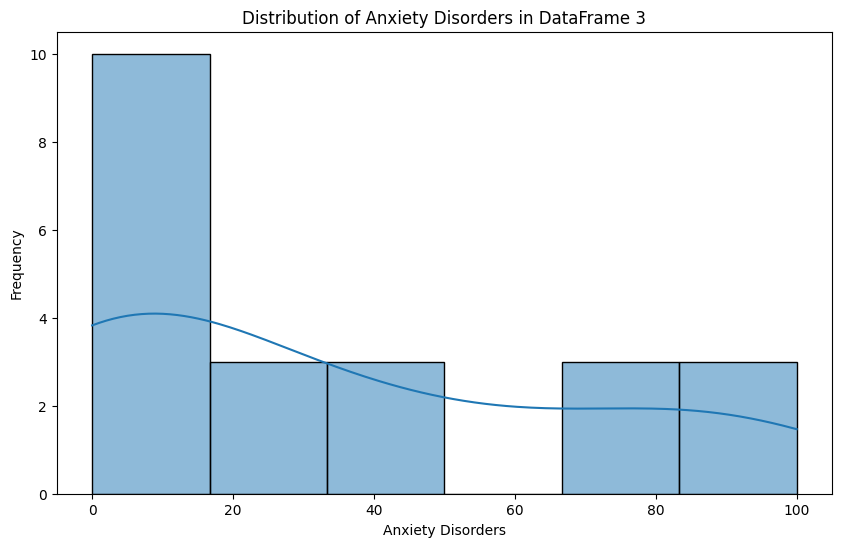


Plotting histograms for DataFrame 4


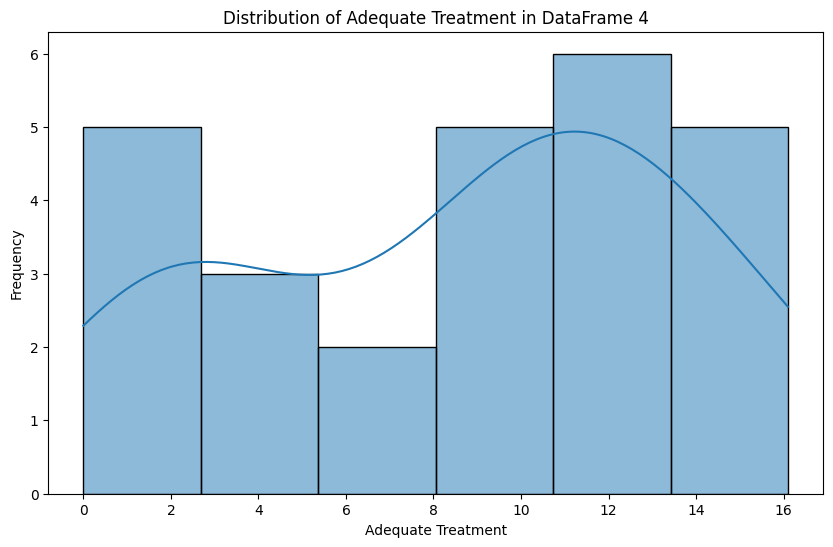

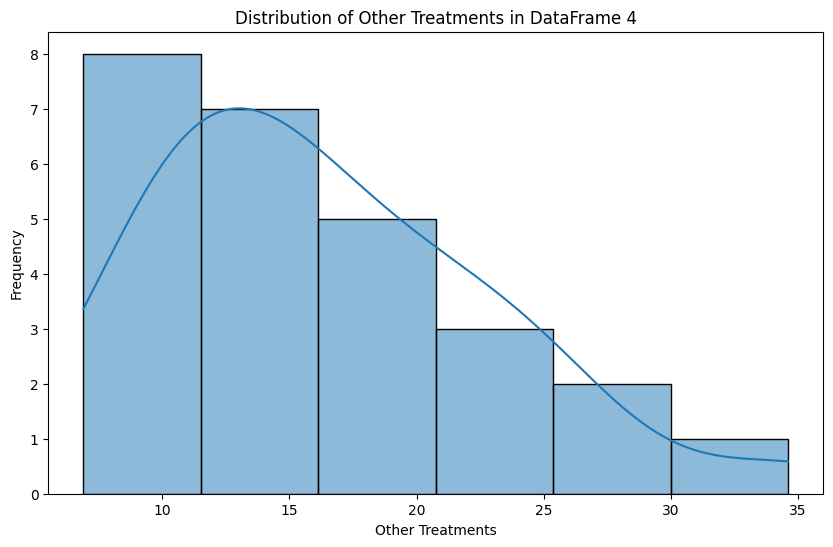

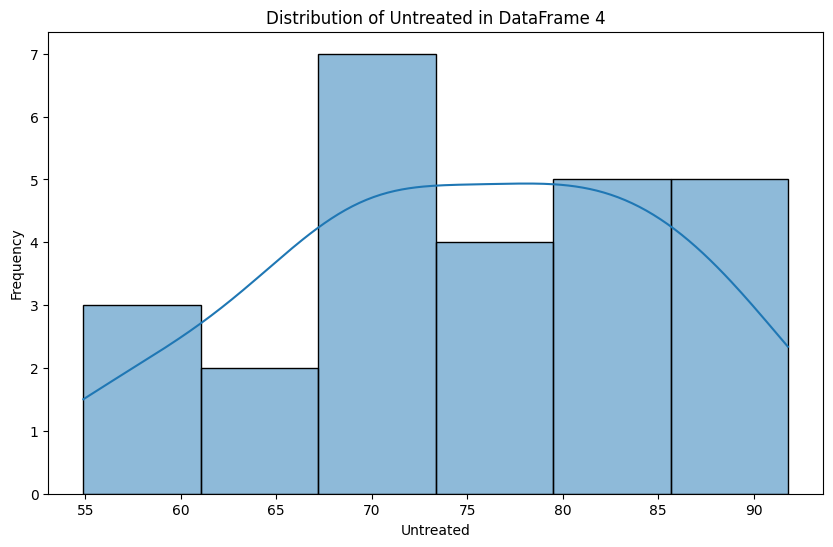


Plotting histograms for DataFrame 5


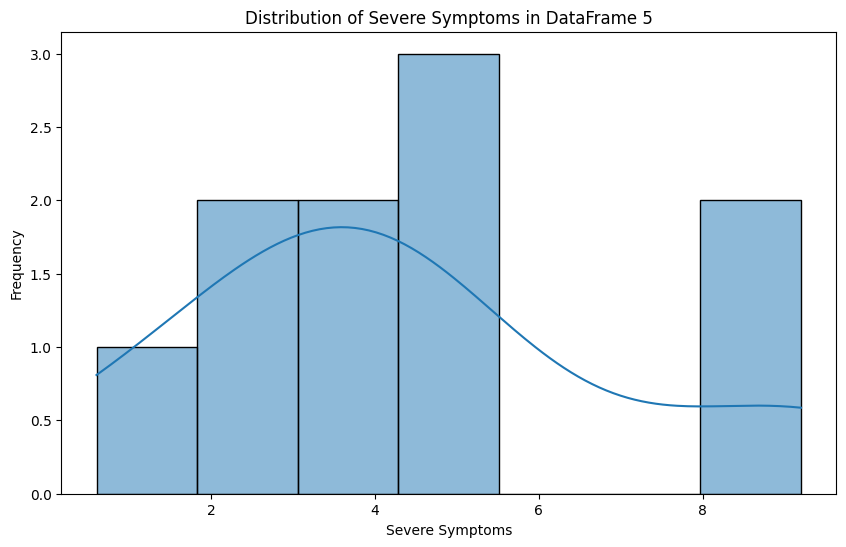

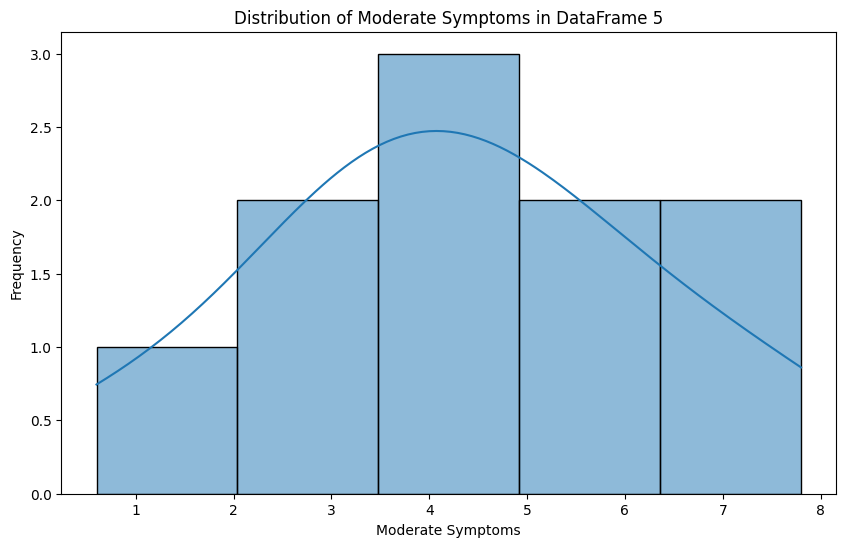

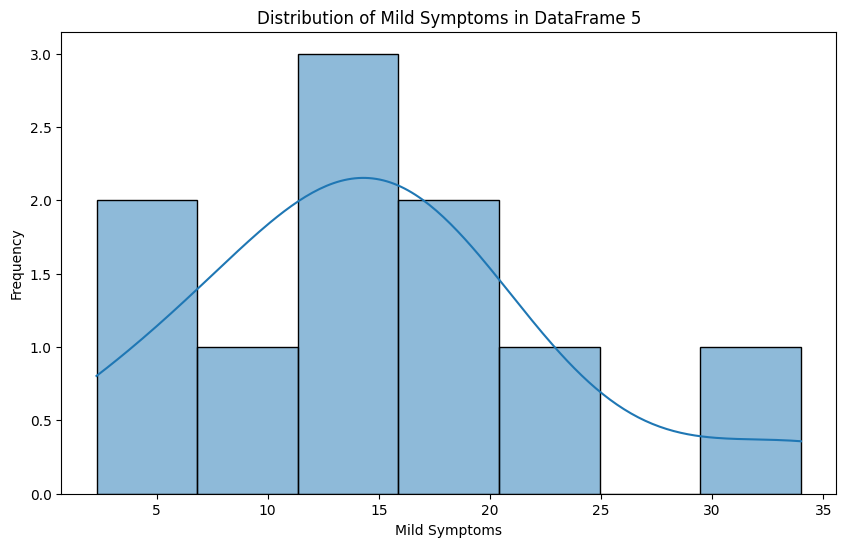

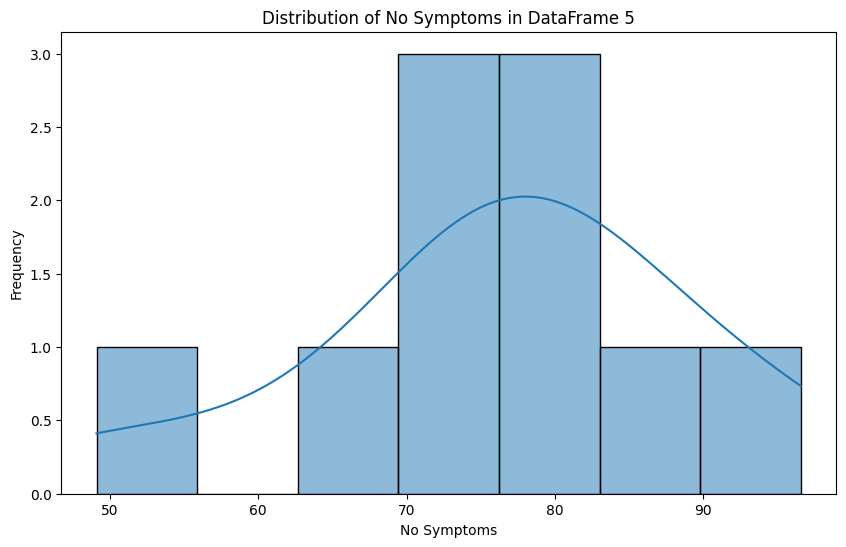


Plotting histograms for DataFrame 6


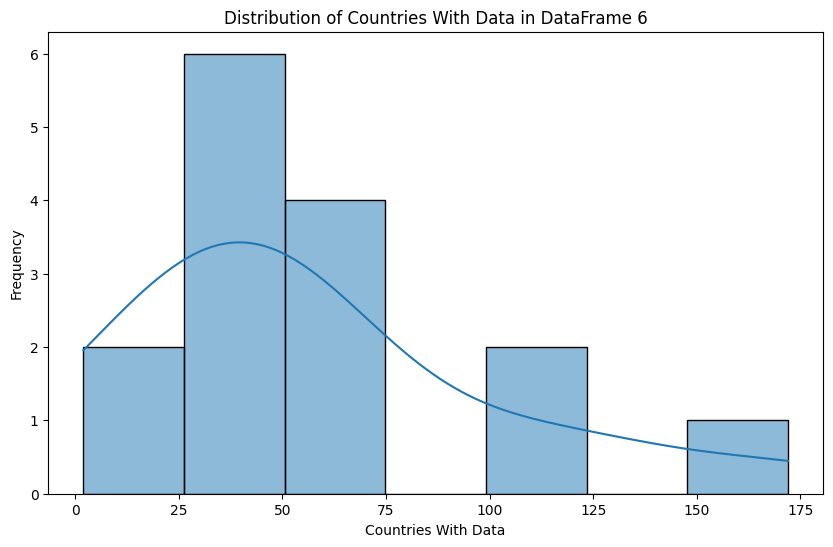

In [19]:
# Function to generate histograms for all numeric columns except 'year'
def plot_histograms(dfs):
  """
    Generates and displays histograms for all numeric columns in each DataFrame
    in the list, skipping the 'year' column if it exists.

    Parameters:
    -----------
    dfs : list of pandas.DataFrame
        A list of DataFrames to plot histograms from.
  """

  for i, df in enumerate(dfs):
    if i != len(dfs) - 1:
      print(f"\nPlotting histograms for DataFrame {i}")
      for col in df.select_dtypes(include='number').columns:
        if col != 'year':  # Skip the 'year' column
          plt.figure(figsize=(10, 6))
          sns.histplot(df[col].dropna(), kde=True) # Drop NA values for plotting
          plt.title(f'Distribution of {col.replace("_", " ").title()} in DataFrame {i}')
          plt.xlabel(col.replace("_", " ").title())
          plt.ylabel('Frequency')
          plt.show()

# Call the function to plot histograms for all numeric columns except 'year'
plot_histograms(dfs)


In [20]:
columns_for_correlation = ['schizophrenia_disorders',
                                 'depression_disorders',
                                 'anxiety_disorders',
                                 'bipolar_disorders',
                                 'eating_disorders']


## Scatter Plots

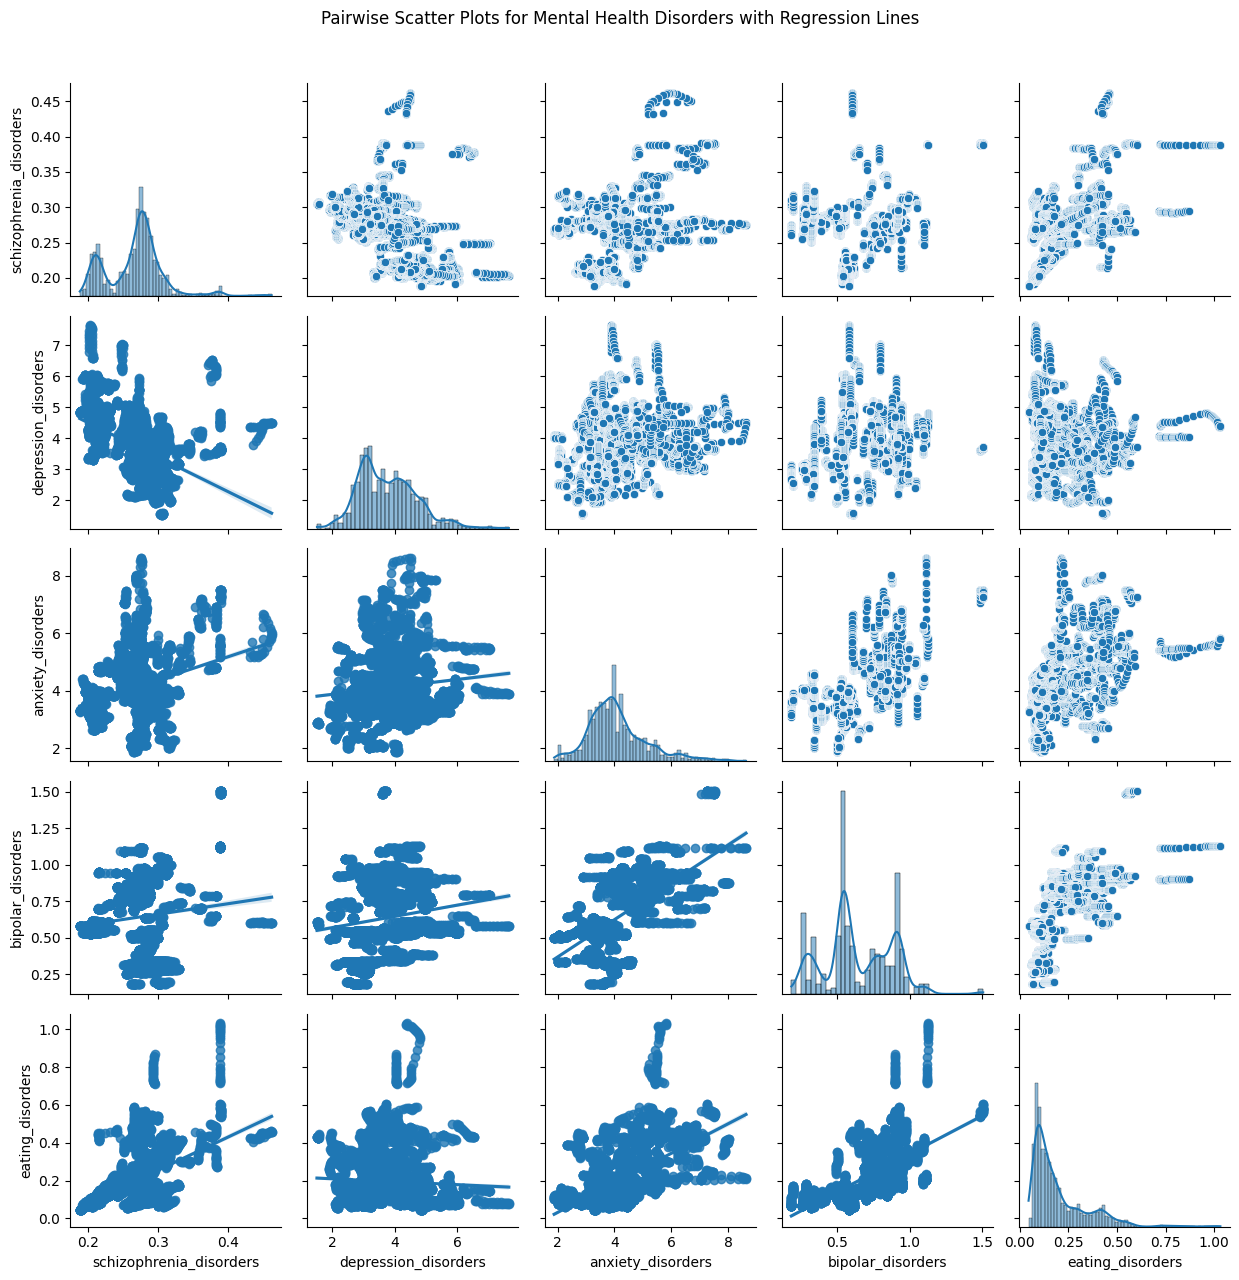

In [21]:
pair_grid = sns.PairGrid(dfs[0], vars=columns_for_correlation)
pair_grid.map_upper(sns.scatterplot)
pair_grid.map_lower(sns.regplot)
pair_grid.map_diag(sns.histplot, kde=True)
plt.suptitle('Pairwise Scatter Plots for Mental Health Disorders with Regression Lines', y=1.02)
plt.tight_layout()
plt.show()
# we need to make the points smaller I think.



Plotting scatter plots for DataFrame 0


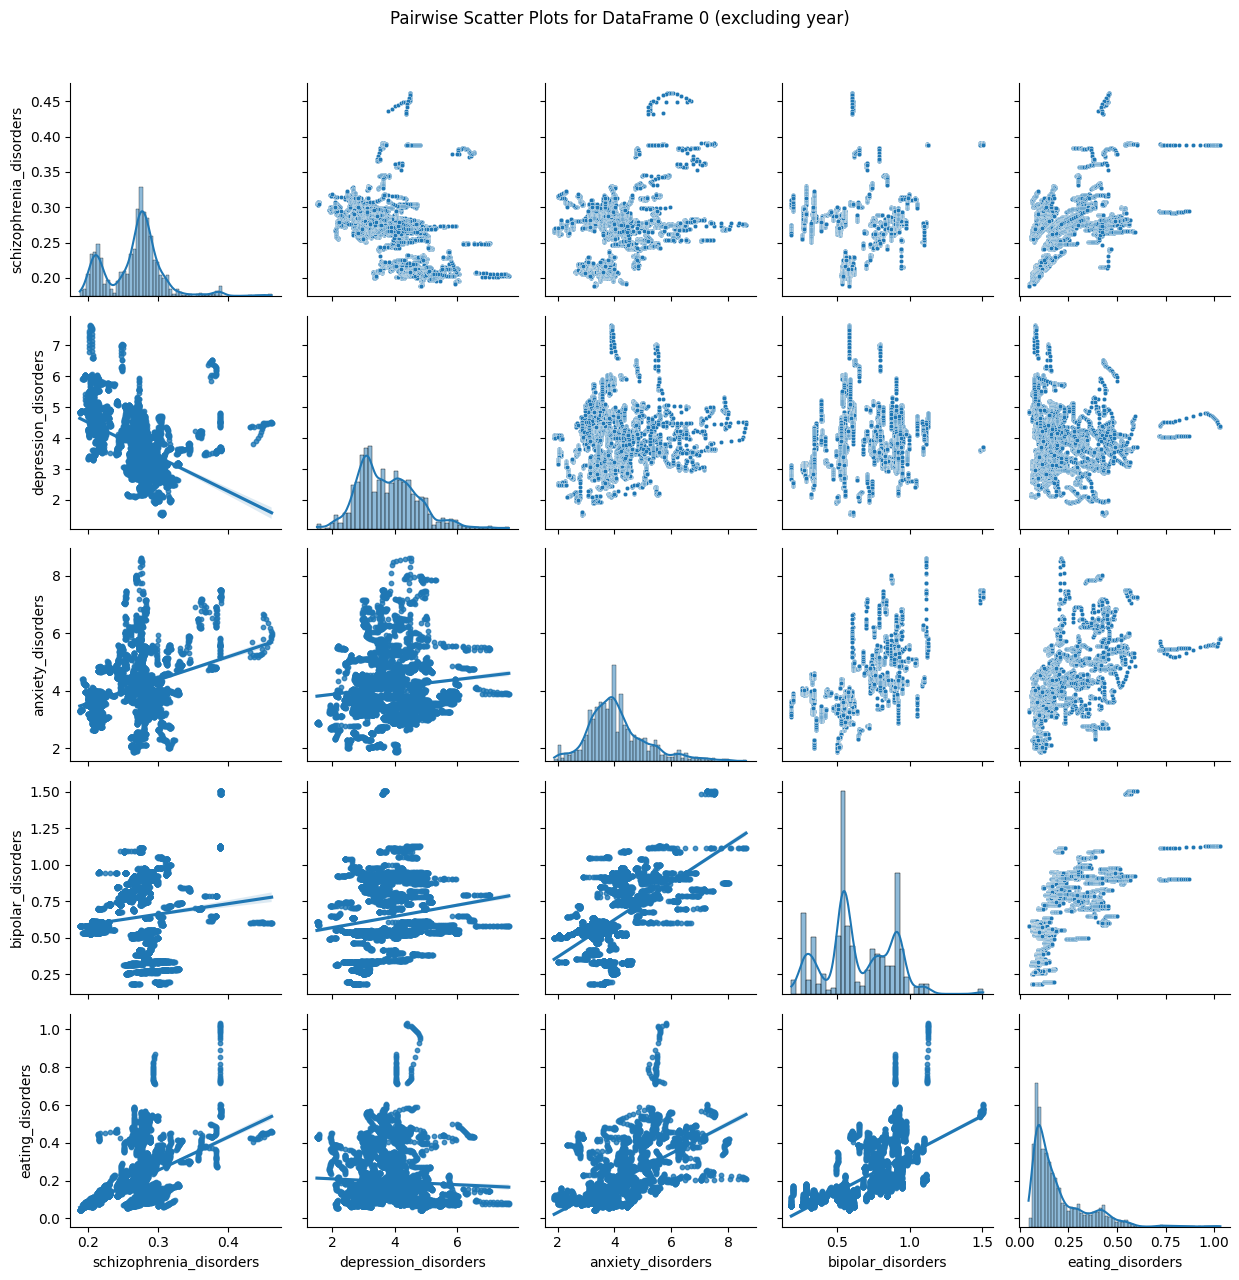


Plotting scatter plots for DataFrame 1


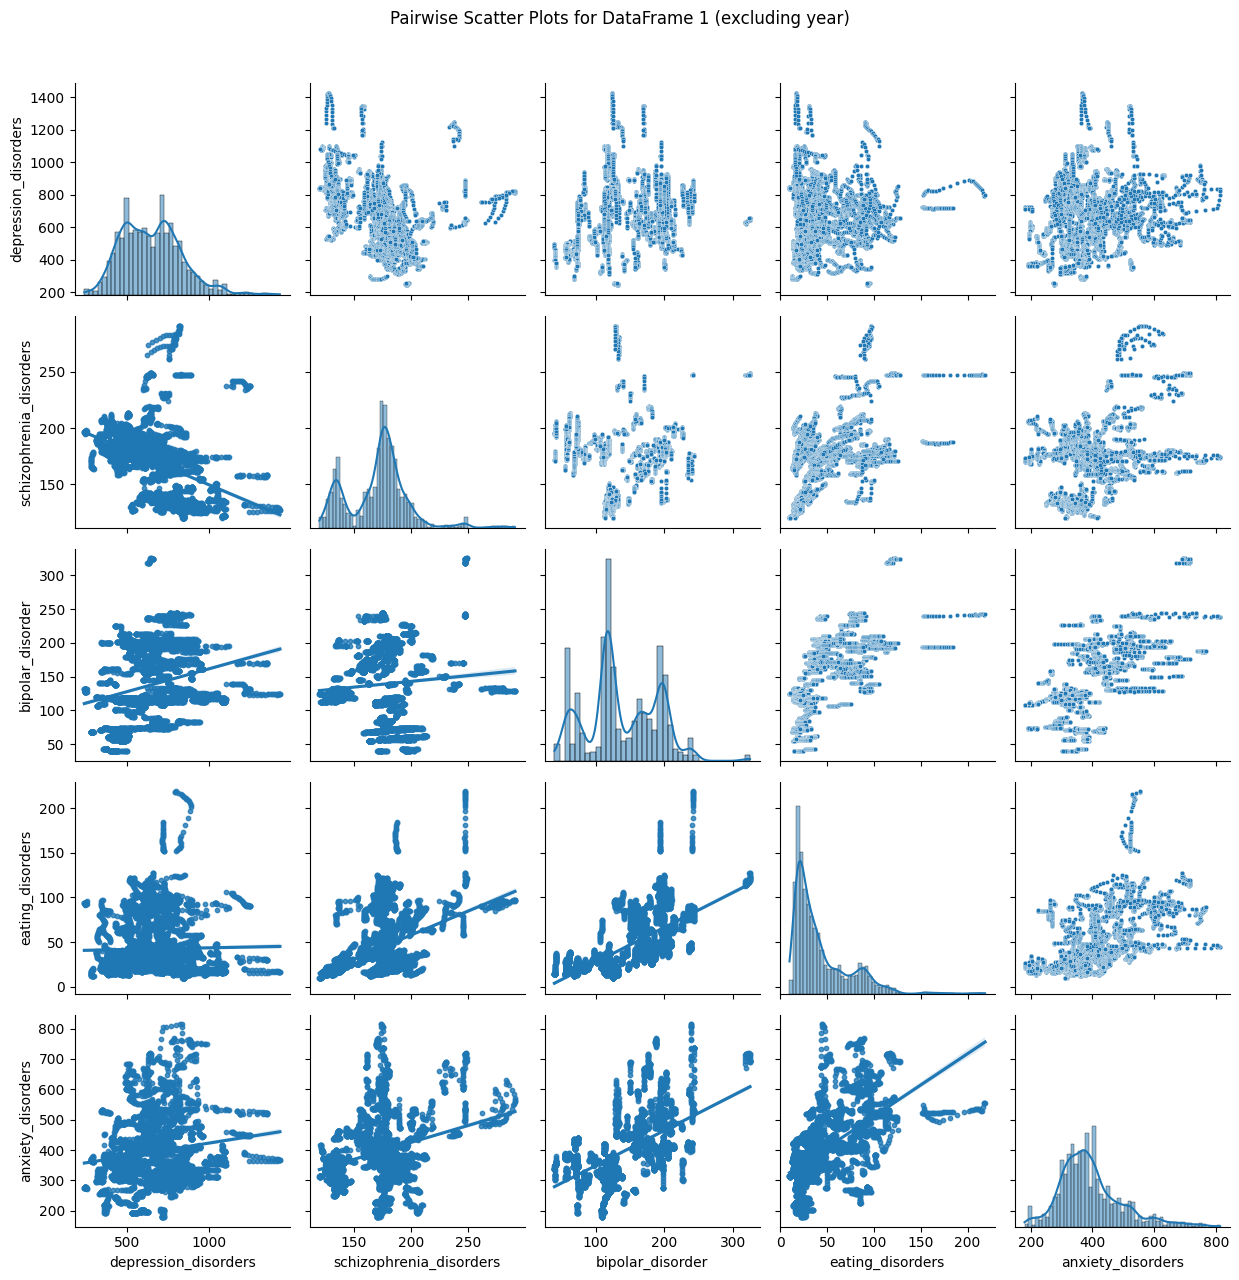


Plotting scatter plots for DataFrame 2
DataFrame 2 has less than two numeric columns to plot scatter plots for (excluding year). Skipping scatter plot.

Plotting scatter plots for DataFrame 3


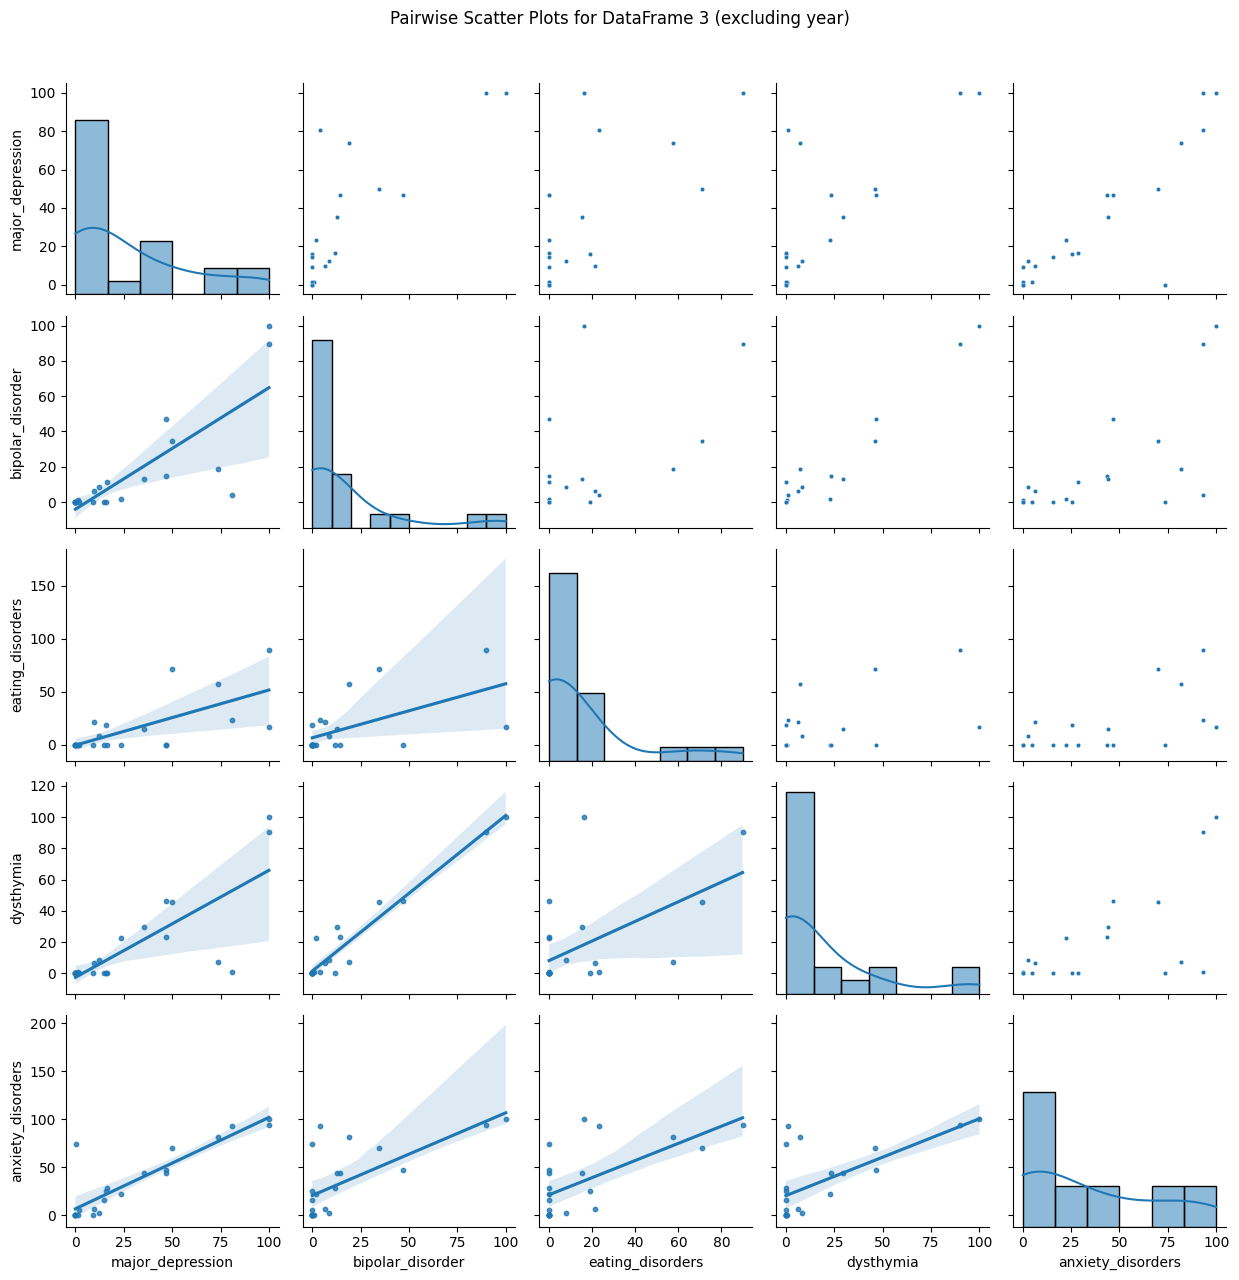


Plotting scatter plots for DataFrame 4


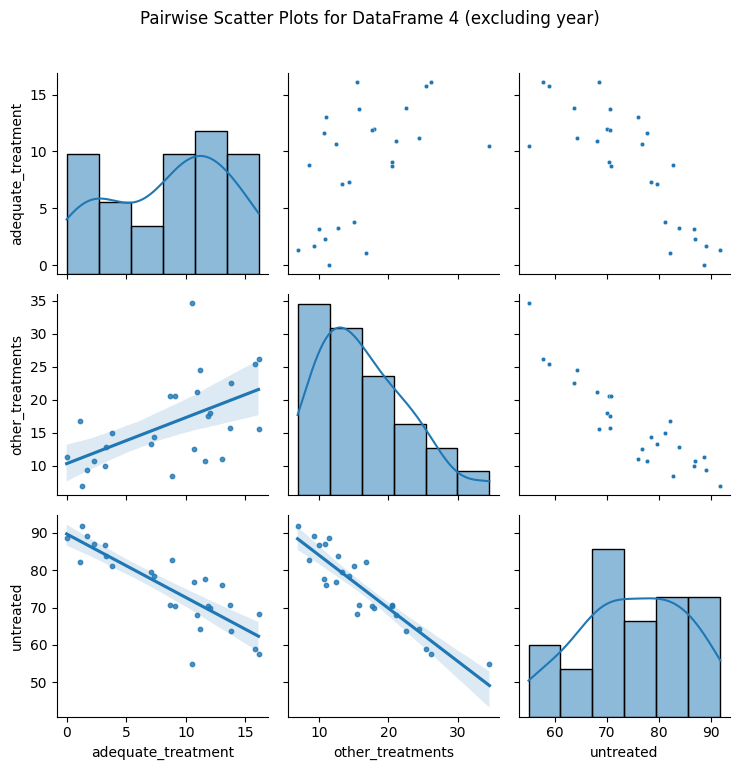


Plotting scatter plots for DataFrame 5


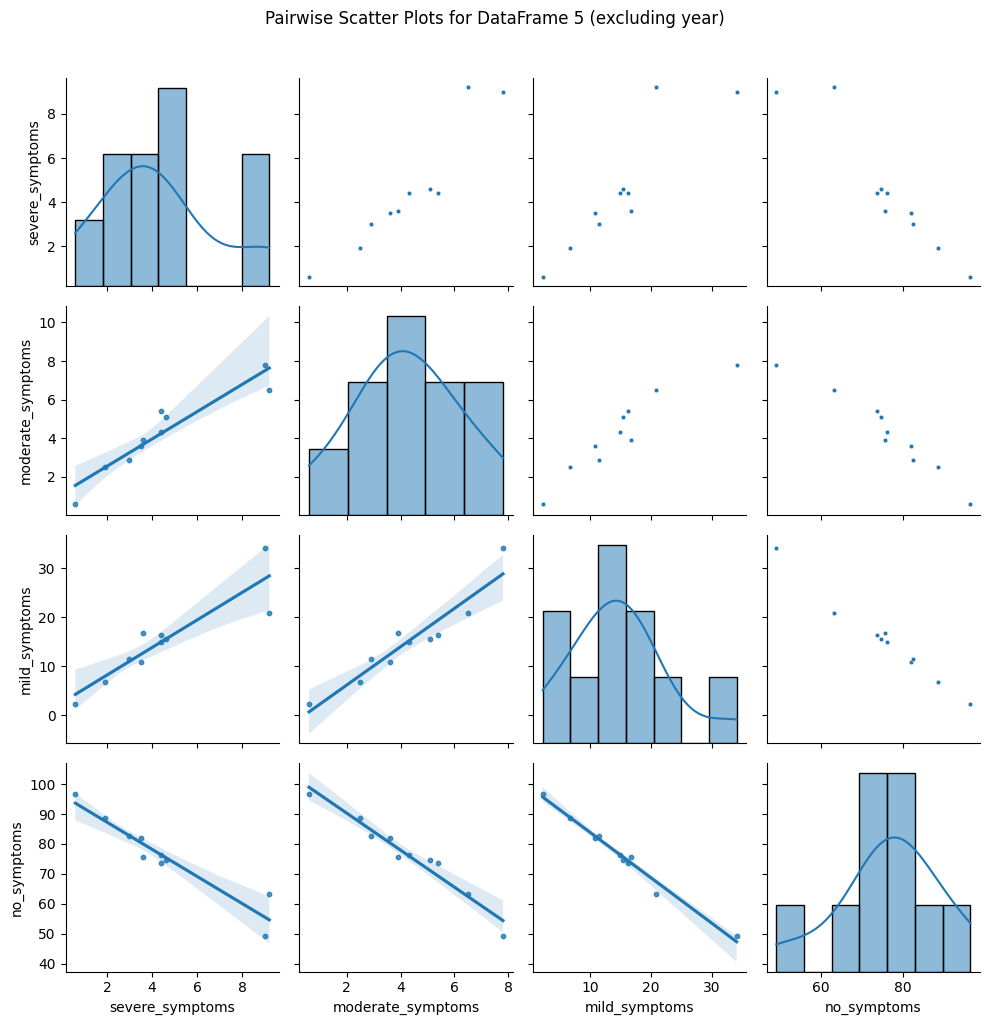


Plotting scatter plots for DataFrame 6
DataFrame 6 has less than two numeric columns to plot scatter plots for (excluding year). Skipping scatter plot.


In [29]:
# Generate more Scatter plots for more datasets
# Function to generate scatter plots for all numeric column pairs except 'year'
def plot_scatterplots(dfs):
  """
    Generates and displays scatter plots for all pairs of numeric columns
    in each DataFrame in the list, skipping the 'year' column if it exists.

    Parameters:
    -----------
    dfs : list of pandas.DataFrame
        A list of DataFrames to plot scatter plots from.
  """
  for i, df in enumerate(dfs):
    if i != len(dfs) - 1:
        print(f"\nPlotting scatter plots for DataFrame {i}")
        numeric_cols = df.select_dtypes(include='number').columns
        # Filter out the 'year' column if it exists
        plot_cols = [col for col in numeric_cols if col != 'year']

        # Create a PairGrid for all pairwise scatter plots of numeric columns
        # Use a subset of columns if there are too many to avoid excessive plotting
        if len(plot_cols) > 1:
            # Limit the number of columns for plotting if it's too large
            max_cols_for_pairplot = 10
            if len(plot_cols) > max_cols_for_pairplot:
                print(f"DataFrame {i} has more than {max_cols_for_pairplot} numeric columns (excluding year). Plotting a subset.")
                # You might want to select specific columns here based on relevance
                # For now, just take the first max_cols_for_pairplot columns
                cols_to_plot = plot_cols[:max_cols_for_pairplot]
            else:
                cols_to_plot = plot_cols

            if len(cols_to_plot) > 1:
                pair_grid = sns.PairGrid(df, vars=cols_to_plot)
                # Use regplot for regression lines
                pair_grid.map_upper(sns.scatterplot, s=10) # smaller points
                pair_grid.map_lower(sns.regplot, scatter_kws={'s': 10}) # smaller points
                pair_grid.map_diag(sns.histplot, kde=True)

                plt.suptitle(f'Pairwise Scatter Plots for DataFrame {i} (excluding year)', y=1.02)
                plt.tight_layout()
                plt.show()
            else:
                print(f"DataFrame {i} has only one numeric column to plot scatter plots for (excluding year). Skipping scatter plot.")
        else:
            print(f"DataFrame {i} has less than two numeric columns to plot scatter plots for (excluding year). Skipping scatter plot.")

# Call the function to plot scatter plots for all datasets, excluding the year column
plot_scatterplots(dfs)


## Correlation and Covariance Heat Map
##### Only applied on dataset #1 and #2
    High correlation and high covariance -> strong linear relationship with
    similar variance scale. -> could be used for linear regression

    High correlation but very low covariance m ay indicate the variables vary
     similarly in pattern but not in magnitude.

    Very low covariance (close to zero) -> almost no shared variance even if
    the correlation is moderate.

#### Dataset 1 Analysis: mental-illnesses-prevalence

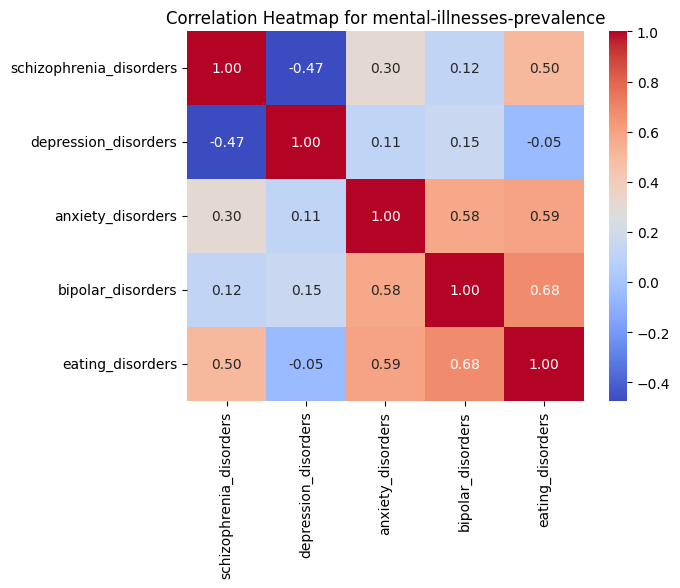

In [23]:
# Calculate correlation matrix for the first DataFrame
corr_matrix = df_skip.corr()

#draw heatmap for correlation matrix for tables that has more than 2 columns
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap for mental-illnesses-prevalence')
plt.show()

| Column                      | Strongest Correlation With                        | Correlation Value | Independent?     |
| --------------------------- | ------------------------------------------------- | ----------------- | ---------------- |
| `schizophrenia_disorders`   | `eating_disorders`                                | **+0.50**         | No               |
| `depression_disorders`      | `schizophrenia_disorders`                         | **–0.47**         | Weak/moderate    |
| `anxiety_disorders`         | `eating_disorders` / `bipolar_disorders`          | **\~0.58–0.59**   |No                |
| `bipolar_disorders`         | `eating_disorders`                                | **+0.68**         | No               |
| `eating_disorders`          | `bipolar_disorders`                               | **+0.68**         | No               |


depression_disorders has weaker correlations with the rest (e.g., only –0.47 with schizophrenia and near-zero with others), so it's the most independent in this set.

All others are moderately correlated, especially with eating disorders and bipolar disorders.


### Covariance Matrix

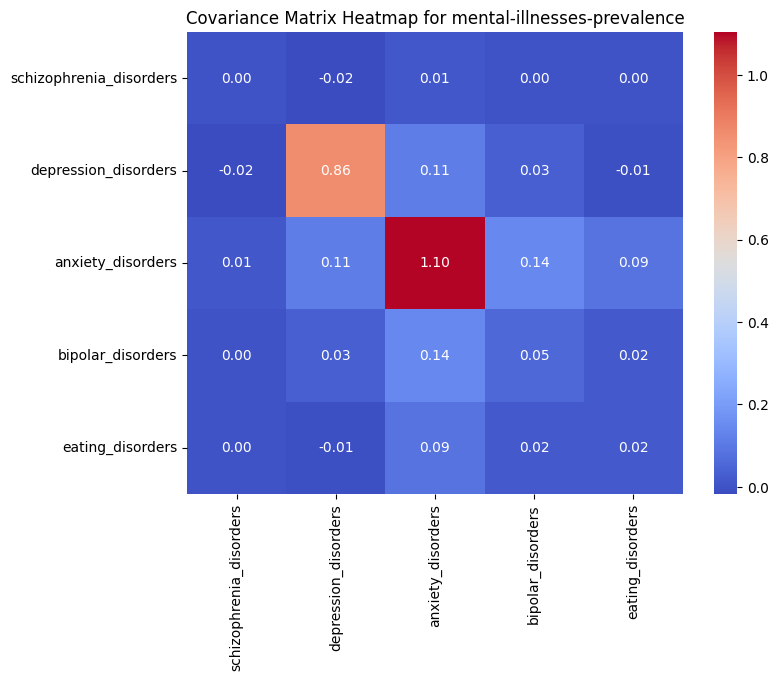

In [24]:
cov_matrix = df_skip.cov()

plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Covariance Matrix Heatmap for mental-illnesses-prevalence")
plt.show()


In [25]:
# Find strong relations based on correlation and covariance
print(find_strong_relation(corr_matrix, cov_matrix))

                Variable 1         Variable 2  Correlation  Covariance
0  schizophrenia_disorders   eating_disorders     0.500656    0.002728
1        anxiety_disorders  bipolar_disorders     0.576230    0.141284
2        anxiety_disorders   eating_disorders     0.594511    0.086427
3        bipolar_disorders   eating_disorders     0.677927    0.021895


| Variable Pair                                    | Correlation | Covariance | Interpretation                                                                              |
| ------------------------------------------------ | ----------- | ---------- | ------------------------------------------------------------------------------------------- |
| **bipolar\_disorders & eating\_disorders**       | **0.678**   | **0.0219** | Strong correlation; moderate covariance — they move together well and on a similar scale.   |
| **anxiety\_disorders & eating\_disorders**       | **0.595**   | **0.0864** | Also strongly related, and the high covariance shows they vary together with similar units. |
| **anxiety\_disorders & bipolar\_disorders**      | **0.576**   | **0.1413** | Strongest covariance in this list -> similar unit spread and mutual variation.               |
| **schizophrenia\_disorders & eating\_disorders** | **0.501**   | **0.0027** | Moderate correlation, but **very small covariance** — may differ in scale significantly.    |



#### Dataset 2 Analysis: burden-disease-from-each-mental-illness

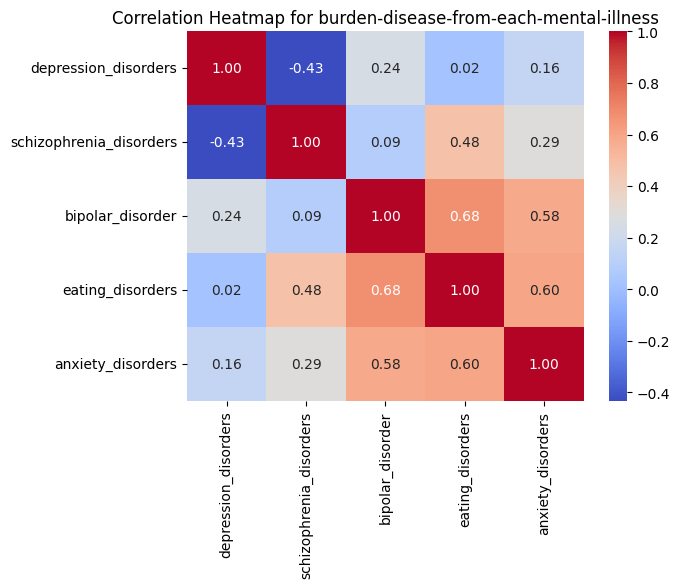

In [26]:
corr_matrix2 = df_skip2.corr()

#draw heatmap for correlation matrix for tables that has more than 2 columns
sns.heatmap(corr_matrix2, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap for burden-disease-from-each-mental-illness')
plt.show()

| Column               | Highest Absolute Correlation | Likely Independent?      |
| -------------------- | ---------------------------- | ------------------------ |
| **Depression**       | –0.43                        | Yes (most independent) |
| **Schizophrenia**    | 0.48                         | Somewhat correlated   |
| **Bipolar, Anxiety** | >0.5 with others             | No (highly correlated) |
| **Eating Disorders** | 0.6+ with 2 others           | No                     |


Depression burden is most independent from the others (nearly uncorrelated or negatively correlated).

Eating disorders, bipolar, and anxiety burdens are highly interrelated

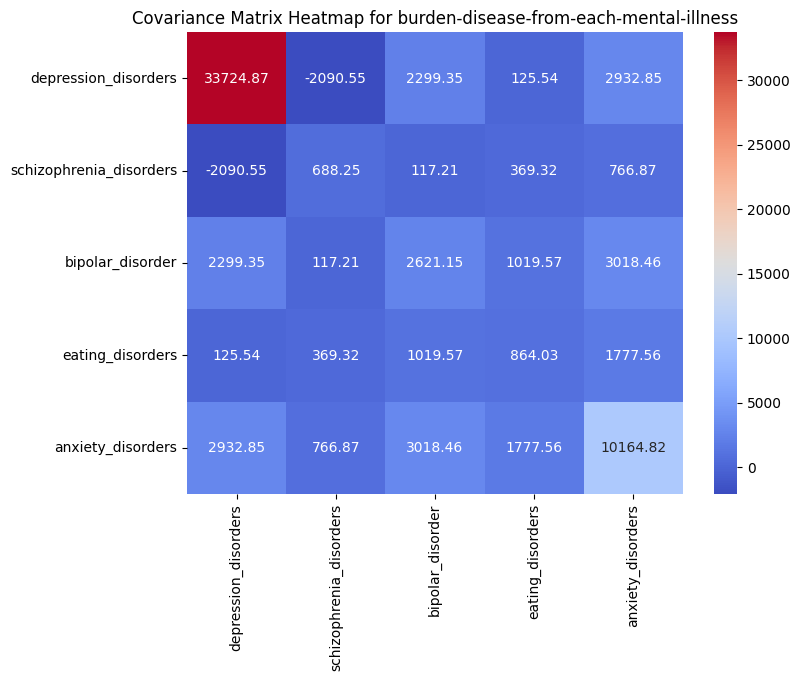

In [27]:
cov_matrix2 = df_skip2.cov()

plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix2, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Covariance Matrix Heatmap for burden-disease-from-each-mental-illness")
plt.show()

In [28]:
print(find_strong_relation(corr_matrix2, cov_matrix2))

         Variable 1         Variable 2  Correlation   Covariance
0  bipolar_disorder   eating_disorders     0.677496  1019.569393
1  bipolar_disorder  anxiety_disorders     0.584777  3018.464103
2  eating_disorders  anxiety_disorders     0.599805  1777.559998


| Pair                            | Correlation | Covariance | Interpretation                                                        |
| ------------------------------- | ----------- | ---------- | --------------------------------------------------------------------- |
| **Bipolar & Eating Disorders**  | 0.677       | 1019.57    | Strong linear relationship, large shared variance                     |
| **Bipolar & Anxiety Disorders** | 0.585       | 3018.46    | Strong correlation with very high covariance (high unit variance too) |
| **Eating & Anxiety Disorders**  | 0.600       | 1777.56    | Strong correlation, moderate-to-high covariance                       |



# Linear Regression

#### Dataset 1 Analysis: mental-illnesses-prevalence

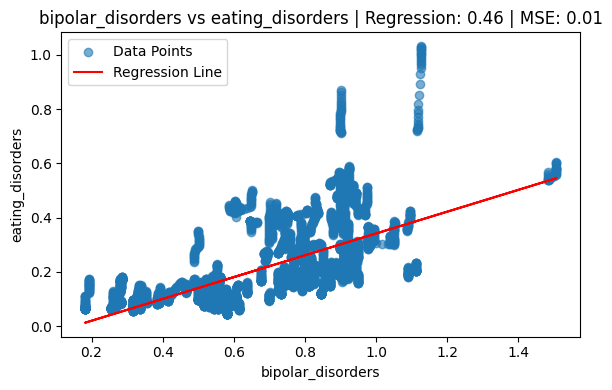

In [73]:
linear_regression_plot(df_skip, 'bipolar_disorders', 'eating_disorders')



Positive linear relationship is clearly visible.

$R^2$ = 0.46:

-> This means about 46% of the variation in eating_disorders is explained by bipolar_disorders

-> This is a moderately strong linear association

MSE = 0.01:

-> Low mean squared error, indicating tight residuals








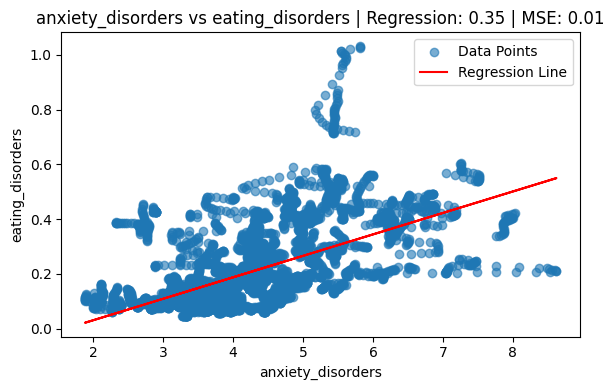

In [74]:
linear_regression_plot(df_skip, 'anxiety_disorders', 'eating_disorders')

A positive linear relationship between anxiety_disorders and eating_disorders $R^2$ =0.35: \
-> About 35% of the variance in eating disorder rates is explained by anxiety disorder rates

MSE = 0.01: \
-> The average squared prediction error is small, which is good

The points show spread increasing slightly as anxiety increases, but overall look fairly evenly distributed



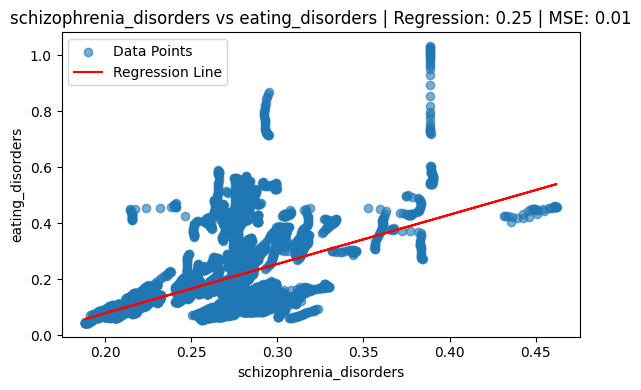

In [75]:

linear_regression_plot(df_skip, 'schizophrenia_disorders', 'eating_disorders')

Positive linear relationship: As schizophrenia_disorders increases, eating_disorders also tends to increase.

$R^2$ = 0.25:

-> About 25% of the variance in eating disorders is explained by schizophrenia disorders — a weak to moderate relationship

-> That's a moderate relationship.

MSE	0.01

-> Very low error, this is expected because the target variable ranges between 0 and 1

#### Dataset 2 Analysis: burden-disease-from-each-mental-illness

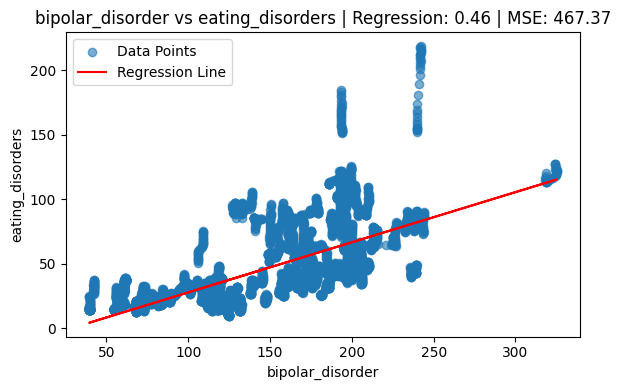

In [76]:
linear_regression_plot(df_skip2, 'bipolar_disorder', 'eating_disorders')

Positive linear trend:
-> The red regression line indicates that as bipolar_disorder values increase, eating_disorders tend to increase as well.

$R^2$ = 0.46:
-> This means 46% of the variance in eating_disorders is explained by bipolar_disorder. That's a moderately strong linear relationship.

MSE = 467.37:
-> On average, the squared error between predicted and actual values is fairly high, which suggests some spread around the regression line, especially at higher values.

The model confirms a statistically significant positive relationship between bipolar_disorder and eating_disorders.
As the number or rate of bipolar disorder cases increases, so does the rate or number of eating disorder cases.

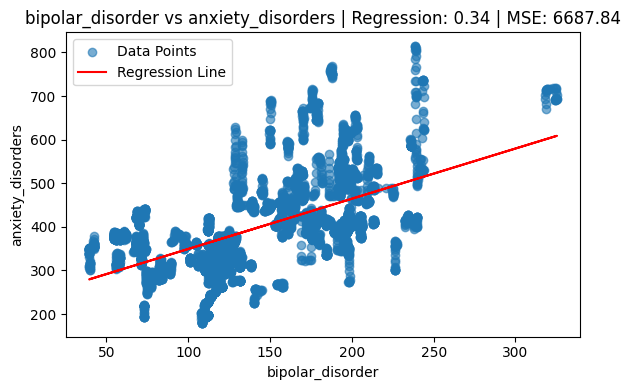

In [77]:
linear_regression_plot(df_skip2, 'bipolar_disorder', 'anxiety_disorders')

The regression line slopes upward, suggesting that as bipolar_disorder increases, anxiety_disorders also tend to increase.

R² = 0.34:
-> This means about 34% of the variance in anxiety_disorders is explained by bipolar_disorder — a moderate relationship.

MSE = 6687.84:
-> The relatively large Mean Squared Error reflects the fact that anxiety_disorders has larger values, possibly ranging from ~200 to 800. So although the MSE looks high, it may be reasonable given the scale.

There is a moderate positive linear relationship between bipolar_disorder and anxiety_disorders.
As bipolar_disorder rates increase, anxiety_disorders tend to increase as well.



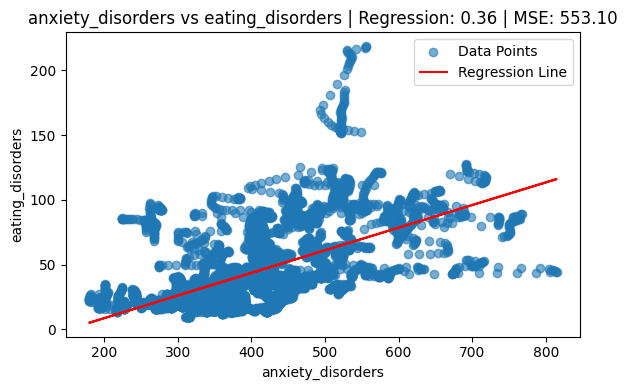

In [78]:
linear_regression_plot(df_skip2, 'anxiety_disorders', 'eating_disorders')

The regression line shows a clear upward slope as eating_disorders increases, anxiety_disorders also tend to increase.

R² = 0.36:
About 36% of the variation in anxiety_disorders is explained by eating_disorders.
-> This is a moderate relationship.

MSE = 6506.91:
Given that anxiety_disorders values range up to ~800, this magnitude is acceptable.

There is a moderate positive relationship between eating disorder rates and anxiety disorder rates.
As eating disorders increase in a region or population, anxiety disorders also tend to increase.

# GLM

#### Dataset 1 Analysis: mental-illnesses-prevalence

In [79]:
# Train GLM on dataset 1 include all disorders to predict eating disorders
# ['schizophrenia_disorders', 'depression_disorders','anxiety_disorders','bipolar_disorders']
X_train_const = sm.add_constant(X_train)
glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian())
glm_results = glm_model.fit()

print(f"Normal GLM Summary: {glm_results.summary()}")

Normal GLM Summary:                  Generalized Linear Model Regression Results                  
Dep. Variable:       eating_disorders   No. Observations:                 5136
Model:                            GLM   Df Residuals:                     5131
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                       0.0066299
Method:                          IRLS   Log-Likelihood:                 5596.4
Date:                Fri, 20 Jun 2025   Deviance:                       34.018
Time:                        16:45:56   Pearson chi2:                     34.0
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8438
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1155      0.005

| Term                          | Coef    | P-value | Interpretation                                                          |
| ----------------------------- | ------- | ------- | ----------------------------------------------------------------------- |
| Intercept                     | -0.1155 | < 0.001 | Baseline eating disorder level when all predictors = 0                  |
|**schizophrenia\_disorders**   | 0.3912  | < 0.001 | Strong positive effect with +0.3912 unit increase in eating\_disorders  |
|**despression\_disorders**     | 0.0346  | < 0.001 | Small but significant positive effect                                   |
|**anxiety\_disorders**         | 0.1312  | < 0.001 | Moderate positive effect                                                |
|**bipolar\_disorders**         | 0.4156  | < 0.001 | Strongest effect and highest impact per unit                            |

We trained a Generalized Linear Model (GLM) using a Gaussian distribution with identity link to predict eating disorders from four mental health predictors. We applied a train-test split (typically 80/20) to better simulate real-world predictive performance.


Null Hypothesis $H_0 \beta_1 = \beta_2 = \beta_3 = \beta_4 = 0:$ None of the predictors have a linear relationship with eating_disorders.

Alternative Hypothesis  $H_a \beta_i \neq 0$: At least one predictor has a significant linear relationship.

All four predictors are statistically significant (P < 0.001), indicating strong evidence to reject null hypothesis and conclude that mental disorders significantly predict eating disorders.

Bipolar and schizophrenia disorders show the highest impact on eating disorder prevalence.

Anxiety and depression also contribute positively, though with smaller magnitudes.

The model supports that increases in any of these disorders are associated with higher rates of eating disorders.


GLM Normal Evaluation:
Train R²: 0.6502, Test R²: 0.6777 (95% CI: 0.6526, 0.7017)
Train MSE: 0.0066, Test MSE: 0.0064


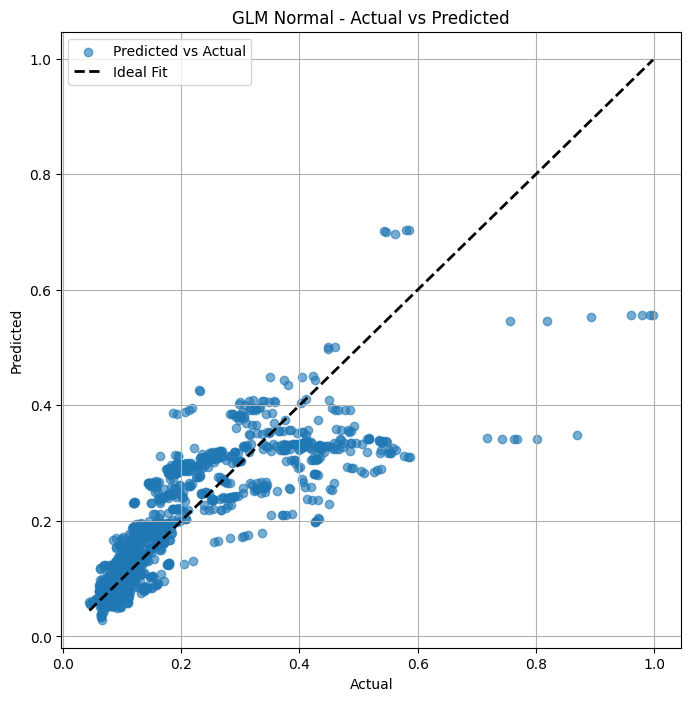

{'r2_train': 0.6501945031458656,
 'r2_test': 0.6776573651975215,
 'r2_test_ci': (0.652620436809952, 0.7016570753891213),
 'mse_train': 0.00662340034343275,
 'mse_test': 0.0064400572663291765,
 'p_value_vs_ref': None}

In [80]:
# predict and evaluate dataset 1
X_test_const = sm.add_constant(X_test)
y_pred = glm_results.predict(X_test_const)

evaluate_model(glm_results, "GLM Normal", X_train_const, y_train, X_test_const, y_test)


# K-Nearest Neighbours Regressor


K-Nearest Neighbors Regressor Evaluation:
Train R²: 0.9952, Test R²: 0.9893 (95% CI: 0.9793, 0.9966)
Train MSE: 0.0001, Test MSE: 0.0002
p-value vs reference model: 0.3926


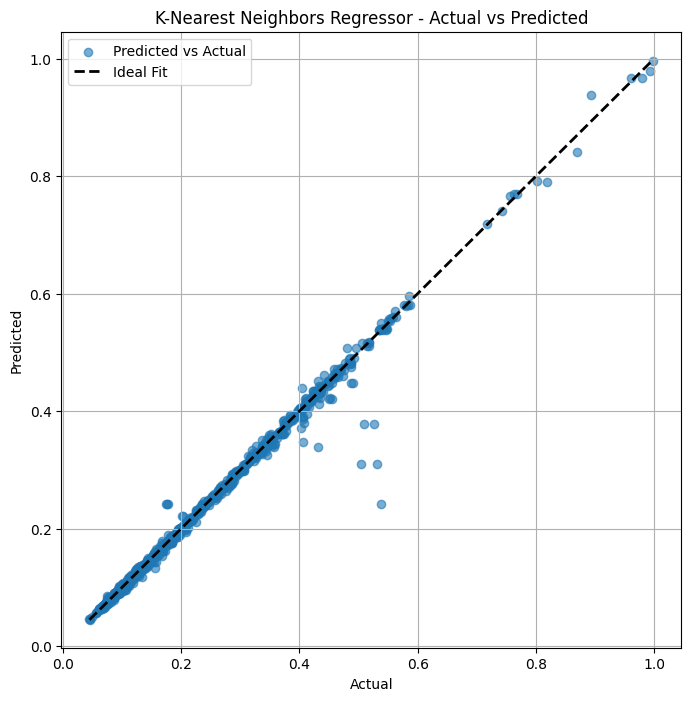

{'r2_train': 0.9952193324457991,
 'r2_test': 0.9893259529014089,
 'r2_test_ci': (0.9792786214603469, 0.9966383440770425),
 'mse_train': 9.051966136923237e-05,
 'mse_test': 0.00021325591825773797,
 'p_value_vs_ref': 0.3925873010815387}

In [81]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a KNN Regressor model
# We can choose the number of neighbors (n_neighbors). Let's start with 5.
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the model using the training data
knn_regressor.fit(X_train, y_train)

evaluate_model(knn_regressor, "K-Nearest Neighbors Regressor", X_train, y_train, X_test, y_test)


# Neural Network - Predictor


Data shapes after splitting:
X_train shape: (5136, 4)
X_test shape: (1284, 4)
y_train shape: (5136,)
y_test shape: (1284,)

Training the Neural Network...


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training finished.
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step

Neural Network Evaluation:
Train R²: 0.9283, Test R²: 0.9205 (95% CI: 0.9024, 0.9351)
Train MSE: 0.0014, Test MSE: 0.0016
p-value vs reference model: 0.0003


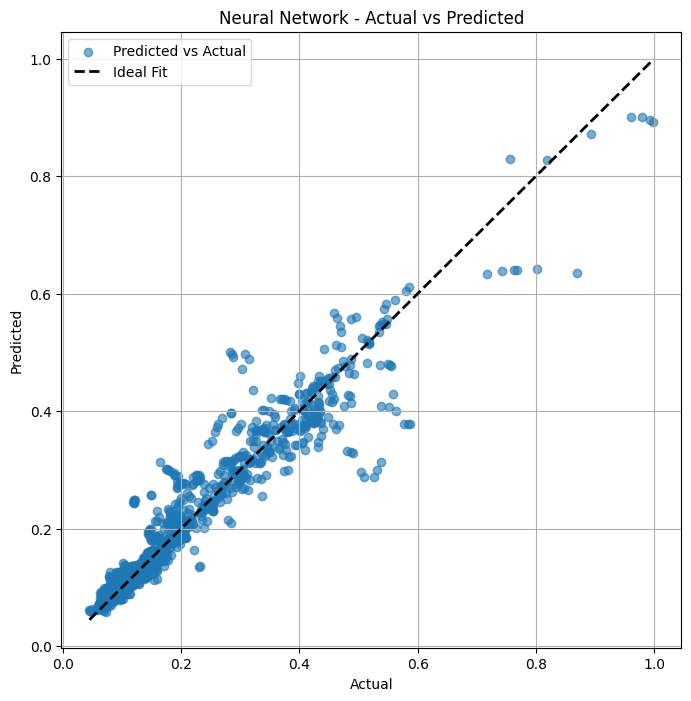

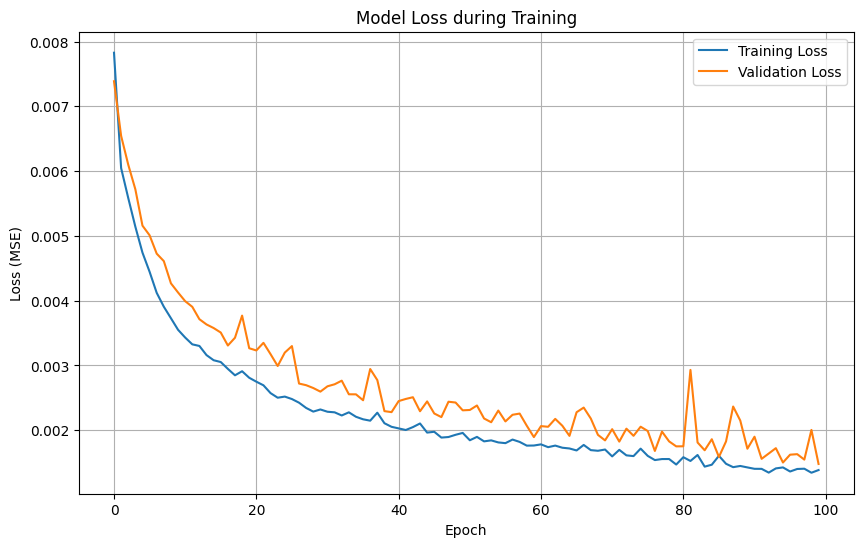

In [82]:
# Use the first DataFrame from the list of dataframes 'dfs'
df1 = dfs[0]

print("\nData shapes after splitting:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Build the Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1) # Output layer for regression (predicting a single continuous value)
])

# Compile the model
model.compile(optimizer='adam', loss='mse') # Using Mean Squared Error as loss for regression

# Train the model
print("\nTraining the Neural Network...")
history = model.fit(X_train, y_train,
                    epochs=100, # Number of training epochs
                    batch_size=32, # Number of samples per gradient update
                    validation_split=0.2, # Use 20% of training data for validation
                    verbose=0) # Set to 1 to see progress

print("Training finished.")

evaluate_model(model, "Neural Network", X_train, y_train, X_test, y_test)

# Optional: Plot training history (loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# Random Forest Regressor - Prediction


Training the Random Forest Regressor...
Training finished.

Random Forest Regressor Evaluation:
Train R²: 0.9995, Test R²: 0.9950 (95% CI: 0.9908, 0.9984)
Train MSE: 0.0000, Test MSE: 0.0001
p-value vs reference model: 0.2411


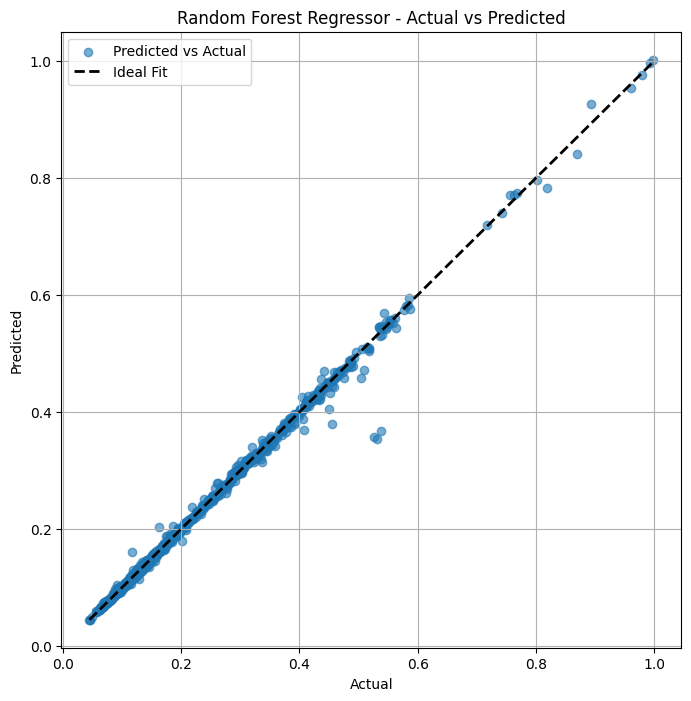


Feature Importances (Regressor):
bipolar_disorders          0.576389
schizophrenia_disorders    0.241544
anxiety_disorders          0.113932
depression_disorders       0.068135
dtype: float64


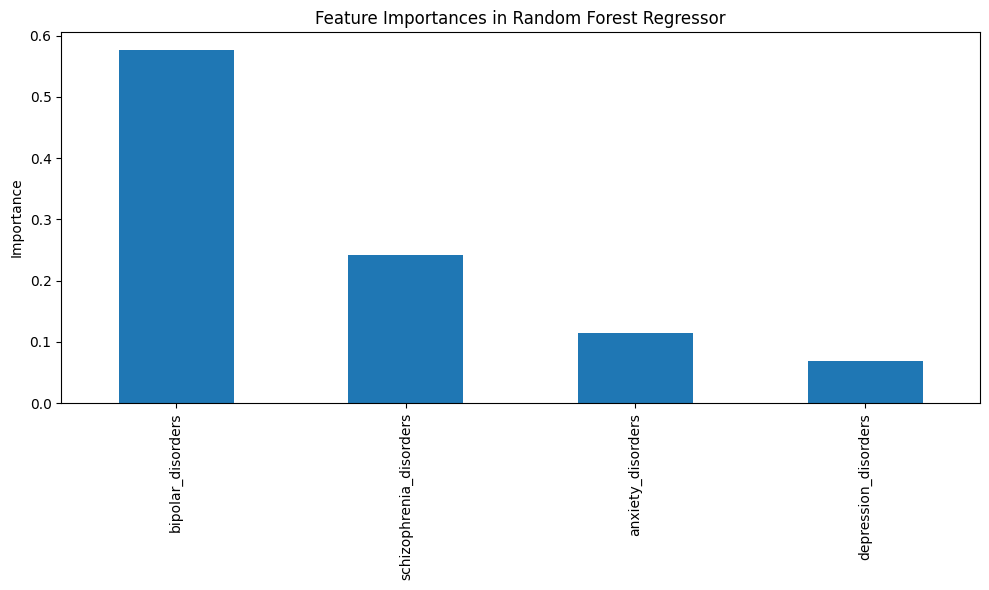

In [83]:
# Random Forest - Regressor
from sklearn.ensemble import RandomForestRegressor

# Build the Random Forest Regressor model
rf_regressor_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores

# Train the model using X_train and the original continuous y_train
print("\nTraining the Random Forest Regressor...")
rf_regressor_model.fit(X_train, y_train)
print("Training finished.")

evaluate_model(rf_regressor_model, "Random Forest Regressor", X_train, y_train, X_test, y_test)

# Optional: Feature Importance for Regressor
print("\nFeature Importances (Regressor):")
feature_importances_regressor = pd.Series(rf_regressor_model.feature_importances_, index=X_model.columns)
feature_importances_regressor = feature_importances_regressor.sort_values(ascending=False)
print(feature_importances_regressor)

# Optional: Plot Feature Importance for Regressor
plt.figure(figsize=(10, 6))
feature_importances_regressor.plot(kind='bar')
plt.title('Feature Importances in Random Forest Regressor')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


# Support Vector Regressor


Training the Support Vector Regressor...
Training finished.

Support Vector Regressor Evaluation:
Train R²: 0.8016, Test R²: 0.8037 (95% CI: 0.7742, 0.8295)
Train MSE: 0.0038, Test MSE: 0.0039
p-value vs reference model: 0.0000


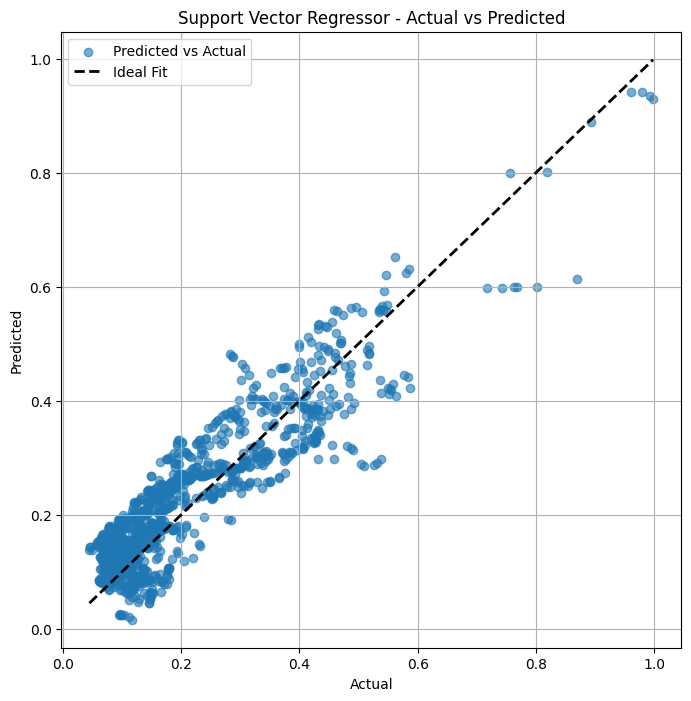

{'r2_train': 0.8015599216264714,
 'r2_test': 0.8036967619638904,
 'r2_test_ci': (0.7741869294454579, 0.8294681346780566),
 'mse_train': 0.0037573682948673676,
 'mse_test': 0.003921926416259081,
 'p_value_vs_ref': 1.1725019741484303e-35}

In [84]:
from sklearn.svm import SVR

# Create a Support Vector Regressor model
# We can choose the kernel (e.g., 'rbf', 'linear', 'poly') and other parameters like C and epsilon
# 'rbf' (Radial Basis Function) is a common choice for non-linear relationships
svr_model = SVR(kernel='rbf')

# Train the model using the training data (scaled features and continuous target)
print("\nTraining the Support Vector Regressor...")
svr_model.fit(X_train, y_train)
print("Training finished.")

evaluate_model(svr_model, "Support Vector Regressor", X_train, y_train, X_test, y_test)


# Exploring the Link Between Universal Health Coverage and Depression

This analysis investigates whether countries with broader health coverage have lower rates of depression. Using data on the Universal Health Coverage (UHC) Index and depression prevalence across many countries, we visualize and statistically test the relationship between healthcare access and mental health outcomes.

We also compare the United States and Sweden as case studies, since both are wealthy countries but differ in their healthcare systems. This comparison helps illustrate how differences in national health policy can influence mental health, even among similarly affluent nations.

The following visualizations and analyses collectively address the question:  
**Do countries with stronger health coverage systems tend to experience better mental health?**

In [85]:
df_uhc = dataframes['GDP.csv']

# See what columns you have
print(df_uhc.columns.tolist())

['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [86]:
df_uhc_long = df_uhc.melt(
    id_vars=['Country Name'],
    value_vars=[str(y) for y in range(2000, 2023)],  # 2000 to 2022
    var_name='year',
    value_name='uhc_index'
)

# Clean column names
df_uhc_long = df_uhc_long.rename(columns={'Country Name': 'entity'})
df_uhc_long['year'] = df_uhc_long['year'].astype(int)
df_uhc_long['uhc_index'] = pd.to_numeric(df_uhc_long['uhc_index'], errors='coerce')
df_uhc_long = df_uhc_long.dropna(subset=['uhc_index'])

print(df_uhc_long.columns)
print(df_uhc_long.head())

Index(['entity', 'year', 'uhc_index'], dtype='object')
                 entity  year  uhc_index
2           Afghanistan  2000       23.0
4                Angola  2000       21.0
5               Albania  2000       43.0
6               Andorra  2000       67.0
8  United Arab Emirates  2000       48.0


## Merging Mental Health and UHC Datasets

Before analyzing the relationship between mental health and Universal Health Coverage (UHC),  
we merge the two datasets on the country (`entity`) and year (`year`) columns.  

To ensure a successful merge, we convert the `year` columns to numeric types in both datasets.  
The merged dataset will include mental health indicators alongside the corresponding UHC index for each country-year.

After merging, some rows may have missing UHC index values.  
We filter the merged dataset to keep only rows where the UHC index is present (`notna()`),  
ensuring that all subsequent analyses use complete data for Universal Health Coverage.  

This filtered dataframe `df_uhc_plot` will be used for plotting and statistical analysis.

In [87]:
df_mental = dataframes['1-mental-illnesses-prevalence.csv']
# Converting column names are lowercase and consistent
df_mental.columns = df_mental.columns.str.lower()

# columns like 'entity' and 'year' will be lowercase
print(df_mental.columns)

#convert 'year' to int (if not already)
df_mental['year'] = pd.to_numeric(df_mental['year'], errors='coerce').astype('Int64')

#same for df_uhc_long just in case
df_uhc_long.columns = df_uhc_long.columns.str.lower()
df_uhc_long['year'] = pd.to_numeric(df_uhc_long['year'], errors='coerce').astype('Int64')

# merge on lowercase 'entity' and 'year'
df_merged = pd.merge(
    df_mental,
    df_uhc_long[['entity', 'year', 'uhc_index']],
    on=['entity', 'year'],
    how='left'
)

df_uhc_plot = df_merged[df_merged['uhc_index'].notna()]

print(df_merged.head())
print(df_merged.shape)

Index(['entity', 'year', 'schizophrenia_disorders', 'depression_disorders',
       'anxiety_disorders', 'bipolar_disorders', 'eating_disorders'],
      dtype='object')
        entity  year  schizophrenia_disorders  depression_disorders  \
0  Afghanistan  1990                 0.223206              4.996118   
1  Afghanistan  1991                 0.222454              4.989290   
2  Afghanistan  1992                 0.221751              4.981346   
3  Afghanistan  1993                 0.220987              4.976958   
4  Afghanistan  1994                 0.220183              4.977782   

   anxiety_disorders  bipolar_disorders  eating_disorders  uhc_index  
0           4.713314           0.703023          0.127700        NaN  
1           4.702100           0.702069          0.123256        NaN  
2           4.683743           0.700792          0.118844        NaN  
3           4.673549           0.700087          0.115089        NaN  
4           4.670810           0.699898          0

### Visualizing the Relationship Between UHC and Depression at the Country Level

To understand how health coverage relates to mental health outcomes, we aggregated the data by country, calculating the average Universal Health Coverage (UHC) index and average depression rate for each country over the entire study period.  

The scatterplot below displays this relationship, revealing broad patterns across nations. It highlights how countries with higher average health coverage tend to have lower average depression rates.  

To deepen this insight, we also include a regression plot with key countries annotated to identify notable outliers or leaders in health coverage and mental health outcomes. These visualizations provide a foundation for interpreting the overall association between healthcare accessibility and depression on a macro level.

In [88]:
print(df_uhc_plot.columns.tolist())


['entity', 'year', 'schizophrenia_disorders', 'depression_disorders', 'anxiety_disorders', 'bipolar_disorders', 'eating_disorders', 'uhc_index']


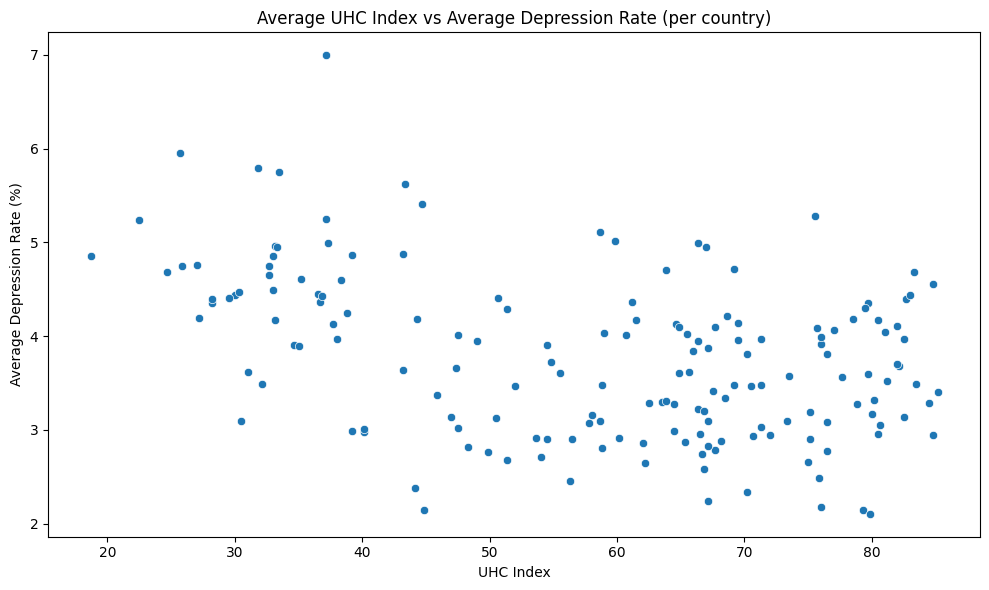

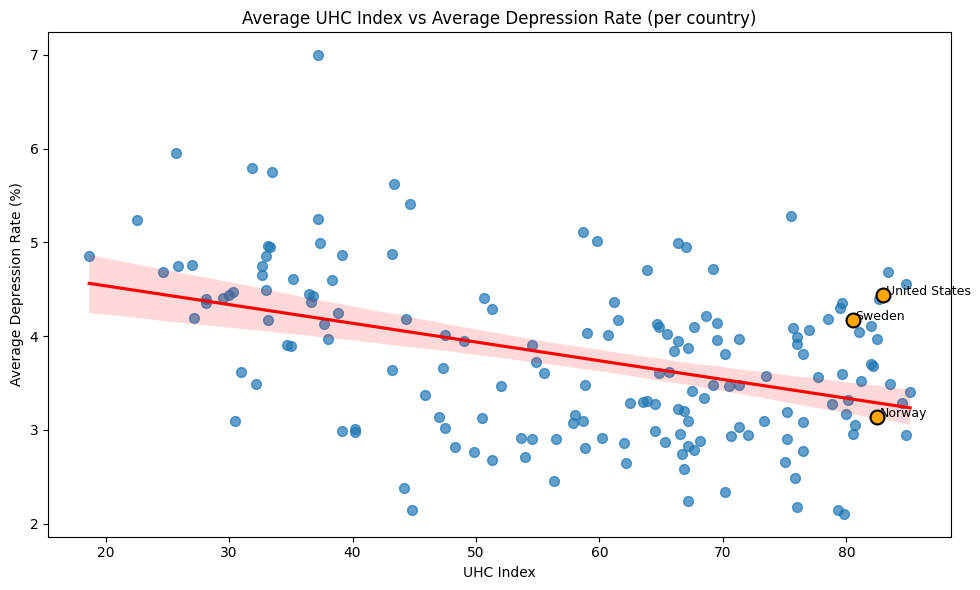

In [89]:
# Aggregate by country once
example_dep_col = 'depression_disorders'
country_means = df_uhc_plot.groupby('entity')[[example_dep_col, 'uhc_index']].mean().reset_index()

# Plot 1: Average UHC vs. average depression rate (scatterplot)
plt.figure(figsize=(10,6))
sns.scatterplot(data=country_means, x='uhc_index', y=example_dep_col)
plt.title('Average UHC Index vs Average Depression Rate (per country)')
plt.xlabel('UHC Index')
plt.ylabel('Average Depression Rate (%)')
plt.tight_layout()
plt.show()

# Plot 2: Average UHC vs. average depression rate with regression line and annotations
plt.figure(figsize=(10,6))
sns.regplot(data=country_means, x='uhc_index', y=example_dep_col,
            scatter_kws={'s': 50, 'alpha': 0.7},
            line_kws={'color': 'red'})

# Annotate and mark notable countries to highlight outliers or interesting points
highlight = ['United States', 'Sweden', 'Norway']
for i, row in country_means.iterrows():
    if row['entity'] in highlight:
        # Add text annotation
        plt.text(row['uhc_index'] + 0.2, row[example_dep_col], row['entity'], fontsize=9)
        # Overlay a distinct marker
        plt.scatter(row['uhc_index'], row[example_dep_col], 
                    s=100, color='orange', edgecolor='black', linewidth=1.5, zorder=5)

plt.title('Average UHC Index vs Average Depression Rate (per country)')
plt.xlabel('UHC Index')
plt.ylabel('Average Depression Rate (%)')
plt.tight_layout()
plt.show()


**Figure 1:** Scatterplot showing the average Universal Health Coverage (UHC) Index versus the average depression rate for each country over the study period. This plot visualizes the overall relationship between healthcare coverage and depression prevalence across nations.

**Figure 2:** Scatterplot of average UHC Index vs. average depression rate with a regression line and highlighted key countries (United States, Sweden, Norway). Distinct markers and labels emphasize outliers and examples, illustrating differences within the global trend.


### Interpretation of Average UHC Index vs. Average Depression Rate Scatterplots

The scatterplots above display the relationship between the average Universal Health Coverage (UHC) Index and the average depression rate for each country over the study period. 

**Plot 1** provides a straightforward visualization of this relationship, showing that countries with higher UHC indices generally tend to have lower average depression rates, suggesting better healthcare coverage may be linked to improved mental health outcomes.

**Plot 2** adds a regression line to quantify this negative association and highlights notable countries such as the United States, Sweden, and Norway. These annotations help identify outliers or exemplars in the data. For instance, Sweden and Norway, with higher UHC scores, appear toward the lower end of depression rates, while the United States stands out as an outlier with a relatively lower UHC index and higher depression rates compared to some peers.

Together, these visualizations support the hypothesis that broader, more effective healthcare coverage is associated with lower depression prevalence at the country level. The distinct markers and annotations provide additional context for interpreting how specific countries compare within this trend.


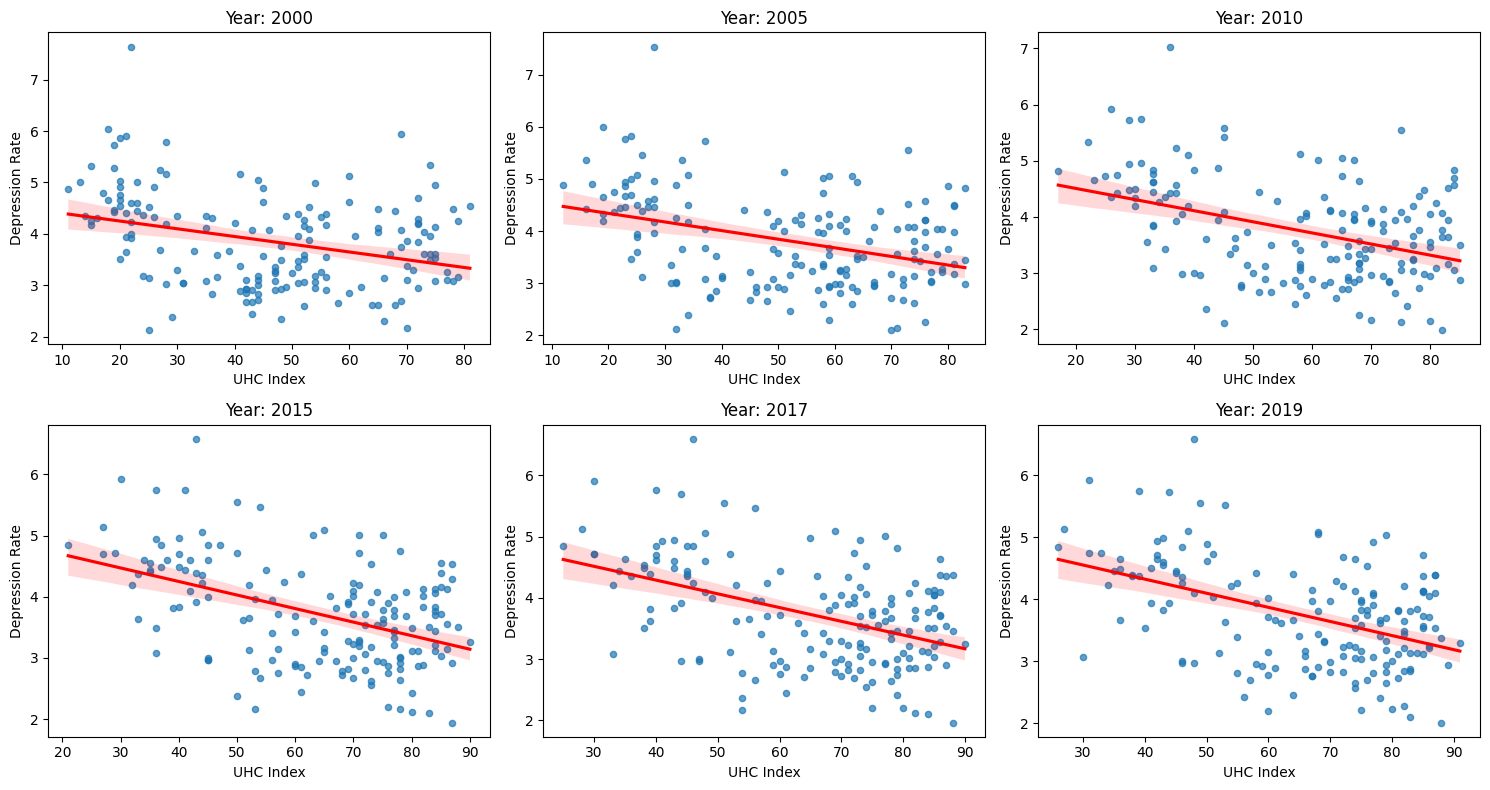

Yearly correlations between UHC and Depression:
2000: r = -0.32, p = 0.0000
2005: r = -0.37, p = 0.0000
2010: r = -0.40, p = 0.0000
2015: r = -0.45, p = 0.0000
2017: r = -0.45, p = 0.0000
2019: r = -0.46, p = 0.0000


In [90]:
# Prepare years and grid layout
years = sorted(df_uhc_plot['year'].dropna().unique())
cols = 3
rows = (len(years) + cols - 1) // cols

plt.figure(figsize=(cols*5, rows*4))

# Plot scatterplots with regression line for each year
for i, year in enumerate(years, 1):
    plt.subplot(rows, cols, i)
    data_year = df_uhc_plot[df_uhc_plot['year'] == year]
    sns.regplot(x='uhc_index', y=example_dep_col, data=data_year,
                scatter_kws={'s': 20, 'alpha': 0.7},
                line_kws={'color': 'red'})
    plt.title(f'Year: {year}')
    plt.xlabel('UHC Index')
    plt.ylabel('Depression Rate')

plt.tight_layout()
plt.show()

# Print yearly Pearson correlation coefficients
print("Yearly correlations between UHC and Depression:")
for year in years:
    data_year = df_uhc_plot[df_uhc_plot['year'] == year]
    r, p = pearsonr(data_year['uhc_index'], data_year[example_dep_col])
    print(f"{year}: r = {r:.2f}, p = {p:.4f}")


**Figure 3:** Year-by-year scatterplots of Universal Health Coverage (UHC) Index versus depression rates, each with a regression line, illustrating the changing relationship across countries over time. The figure shows a consistent negative trend between health coverage and depression rates from 2000 to 2019.


### Interpretation of Year-by-Year Scatterplots and Correlation Analysis

The year-by-year scatterplots illustrate the relationship between the Universal Health Coverage (UHC) Index and depression rates across countries for each year in the study period. 

The Pearson correlation coefficients for each year, shown below the plots, reveal a consistently significant negative correlation between UHC and depression rates. Specifically:

- In 2000, the correlation coefficient was -0.32, indicating a moderate inverse relationship.
- This negative correlation strengthened over time, reaching -0.46 by 2019.
- All p-values are effectively zero, indicating these correlations are statistically significant.

These results suggest that countries with better health coverage tend to have lower depression rates, and this association has become stronger over the last two decades. The scatterplot's visual regression lines complement these findings by showing a clear downward trend each year.

Overall, the yearly analysis reinforces the hypothesis that improvements in universal health coverage are linked to better mental health outcomes globally.


### Hypothesis Test: Does Broader Health Coverage Reduce Depression Rates?

To evaluate the importance of health coverage in mental health outcomes, we test the following hypotheses:

- **Null hypothesis (H₀):** There is no correlation between the Universal Health Coverage (UHC) Index and depression rates across countries (ρ = 0).
- **Alternative hypothesis (H₁):** There is a significant negative correlation between the UHC Index and depression rates across countries (ρ < 0).

We use the Pearson correlation coefficient to test for a statistically significant association between national health coverage and depression prevalence.



In [91]:
import numpy as np
from scipy.stats import pearsonr, norm

# Prepare your variables
x = country_means['uhc_index']
y = country_means[example_dep_col]

# Calculate Pearson correlation and p-value
r, p_value = pearsonr(x, y)

# Function to calculate 95% CI for Pearson r
def pearsonr_ci(r, n, alpha=0.05):
    if abs(r) == 1:
        return r, r
    fisher_z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z = norm.ppf(1 - alpha / 2)
    lo = fisher_z - z * se
    hi = fisher_z + z * se
    return np.tanh(lo), np.tanh(hi)

# Calculate confidence interval
n = len(x)
ci_low, ci_high = pearsonr_ci(r, n)

# Print the output rounded to two decimals
print(f"Pearson r: {r:.2f}")
print(f"P-value: {p_value:.2f}")
print(f"95% Confidence Interval: [{ci_low:.2f}, {ci_high:.2f}]")


Pearson r: -0.41
P-value: 0.00
95% Confidence Interval: [-0.53, -0.28]


### Interpretation

The Pearson correlation coefficient between the Universal Health Coverage (UHC) Index and depression prevalence is **r = -0.41**, with a 95% confidence interval of [-0.53, -0.28] and a p-value of less than 0.001. Since the p-value is less than 0.05, we can reject the null hypothesis of no association. This provides strong evidence that, on average, countries with higher UHC Index scores tend to have lower rates of depression. The confidence interval further supports that this negative association is unlikely to be due to random chance and is consistent across the countries studied.

### Policy Implication

This finding highlights the importance of investing in comprehensive and accessible healthcare systems. Strengthening national health coverage may help reduce the burden of depression and improve population mental health outcomes worldwide.



### Regression Analysis: UHC Predicting Depression

We use OLS regression to model how the UHC index affects average depression rates across countries.  
The results show the strength and significance of this relationship.


In [92]:
import statsmodels.api as sm

for year in years:
    data_year = df_uhc_plot[df_uhc_plot['year'] == year]
    X = data_year['uhc_index']
    y = data_year[example_dep_col]
    X = sm.add_constant(X)  # Adds intercept
    model = sm.OLS(y, X).fit()
    print(f"OLS Regression Results for Year {year}")
    print(model.summary())
    print("\n" + "-"*80 + "\n")


OLS Regression Results for Year 2000
                             OLS Regression Results                             
Dep. Variable:     depression_disorders   R-squared:                       0.104
Model:                              OLS   Adj. R-squared:                  0.098
Method:                   Least Squares   F-statistic:                     19.34
Date:                  Fri, 20 Jun 2025   Prob (F-statistic):           1.94e-05
Time:                          16:46:31   Log-Likelihood:                -213.97
No. Observations:                   169   AIC:                             431.9
Df Residuals:                       167   BIC:                             438.2
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Statistical Analysis Summary

- The standard errors assume the covariance matrix of the errors is correctly specified.

- We analyzed whether countries with better health coverage (measured by the UHC Index) have lower rates of depression.

- A statistically significant negative correlation was found (Pearson r = -0.41, p < 0.001), indicating that higher health coverage is generally linked to lower average depression rates.

- Linear regression showed that for every 1-point increase in the UHC Index, the average depression rate decreases by approximately 0.02 percentage points (95% CI: -0.027 to -0.013; t = -5.87, p < 0.001).

- Additionally, year-by-year analyses using ordinary least squares (OLS) regression confirmed this negative association over time, with regression coefficients remaining consistently negative and statistically significant across all years analyzed.

- These results confirm a significant and meaningful association between stronger health coverage and reduced depression rates across countries and over time.

---

### Layman’s Summary

Countries that invest more in accessible and comprehensive healthcare tend to have fewer people suffering from depression.  
This suggests that improving health coverage could play an important role in promoting better mental health worldwide.


### Case Study: Comparing Sweden and the United States


In [93]:
# Load your country means dataframe (if not already loaded)
print(country_means[country_means['entity'].isin(['Sweden', 'United States'])])

# Check if US is listed differently in UHC data
print(df_uhc_long[df_uhc_long['entity'].str.contains('United States', case=False)])

# Or check for missing values
print(df_uhc_long[df_uhc_long['entity'] == 'United States']['uhc_index'])



            entity  depression_disorders  uhc_index
147         Sweden              4.168604       80.5
162  United States              4.434055       83.0
             entity  year  uhc_index
251   United States  2000       78.0
1581  United States  2005       81.0
2911  United States  2010       83.0
4241  United States  2015       85.0
4773  United States  2017       86.0
5305  United States  2019       85.0
5837  United States  2021       86.0
251     78.0
1581    81.0
2911    83.0
4241    85.0
4773    86.0
5305    85.0
5837    86.0
Name: uhc_index, dtype: float64


In [94]:
sweden = country_means[country_means['entity'] == 'Sweden']
us = country_means[country_means['entity'] == 'United States']

print("Sweden:")
print(f"  Avg UHC Index: {sweden['uhc_index'].values[0]:.1f}")
print(f"  Avg Depression Rate: {sweden[example_dep_col].values[0]:.2f}")

print("United States:")
print(f"  Avg UHC Index: {us['uhc_index'].values[0]:.1f}")
print(f"  Avg Depression Rate: {us[example_dep_col].values[0]:.2f}")


Sweden:
  Avg UHC Index: 80.5
  Avg Depression Rate: 4.17
United States:
  Avg UHC Index: 83.0
  Avg Depression Rate: 4.43


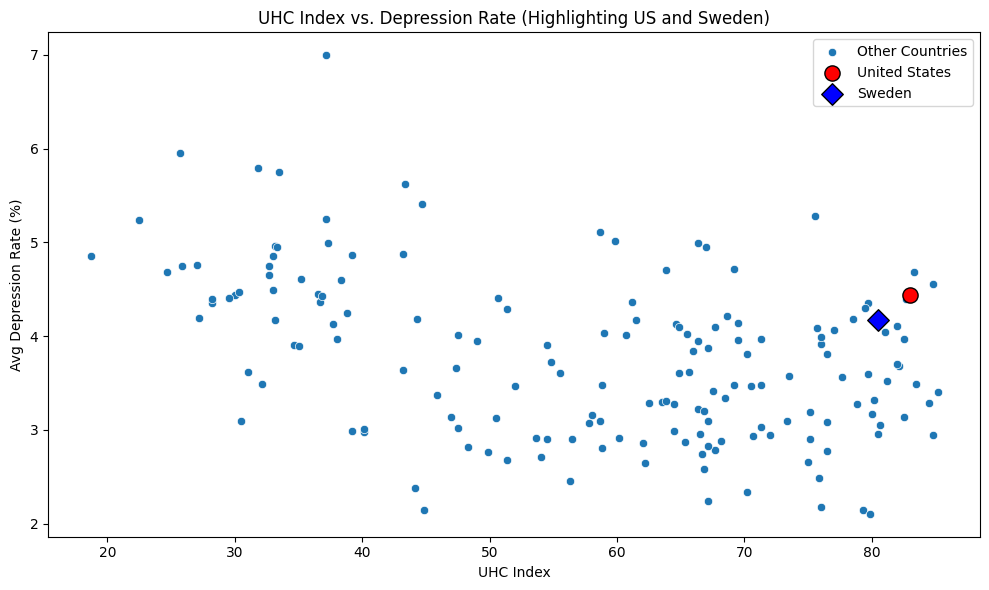

In [95]:
others = country_means[(country_means['entity'] != 'United States') & (country_means['entity'] != 'Sweden')]

plt.figure(figsize=(10,6))
sns.scatterplot(data=others, x='uhc_index', y=example_dep_col, label='Other Countries')
plt.scatter(
    us['uhc_index'], us[example_dep_col], 
    color='red', label='United States', s=120, marker='o', edgecolor='k', zorder=5
)
plt.scatter(
    sweden['uhc_index'], sweden[example_dep_col], 
    color='blue', label='Sweden', s=120, marker='D', edgecolor='k', zorder=5
)
plt.title('UHC Index vs. Depression Rate (Highlighting US and Sweden)')
plt.xlabel('UHC Index')
plt.ylabel('Avg Depression Rate (%)')
plt.legend()
plt.tight_layout()
plt.show()


**Figure 4:** Scatterplot of Universal Health Coverage (UHC) Index versus average depression rate for all countries, highlighting the United States (red circles) and Sweden (blue diamonds). This figure illustrates the relative positions of these two countries within the global context, emphasizing differences in health coverage and depression outcomes.


In [96]:
uhc_diff = us['uhc_index'].values[0] - sweden['uhc_index'].values[0]
dep_diff = sweden[example_dep_col].values[0] - us[example_dep_col].values[0]

print(f"Sweden's UHC Index is higher than the US by {abs(uhc_diff):.1f} points.")
print(f"Sweden's depression rate is lower than the US by {abs(dep_diff):.2f} percentage points.")


Sweden's UHC Index is higher than the US by 2.5 points.
Sweden's depression rate is lower than the US by 0.27 percentage points.


### Interpretation
Although the United States has a slightly higher average Universal Health Coverage (UHC) Index than Sweden, Sweden exhibits a lower average depression rate. This suggests that while broader health coverage is an important factor in mental health outcomes, other elements such as healthcare quality, access to mental health services, and social determinants of health also play critical roles.

This case study underscores the complexity of health systems and mental health outcomes, highlighting that UHC alone does not capture all the nuances affecting depression prevalence.

---

### Layman’s Summary
Even though the U.S. invests slightly more in health coverage overall, Sweden has fewer people experiencing depression. This means that simply  having broader health coverage isn’t the whole story—how well the healthcare system works, the availability of mental health support, and other social factors also make a big difference in people’s mental well-being.


### Conclusion

Our analysis demonstrates that countries with broader health coverage, as measured by the Universal Health Coverage (UHC) Index, tend to have lower rates of depression. This relationship is statistically significant and consistent across multiple analytical approaches. A direct comparison between the United States and Sweden further illustrates how national health policies can influence mental health outcomes—even among countries with similar economic status. Strengthening health coverage may therefore be a crucial step toward improving mental health at the population level worldwide.


# Results



Model Evaluation Results:
                           model  r2_train   r2_test  r2_test_ci_lower  \
0                     GLM Normal  0.650195  0.677657          0.652620   
1  K-Nearest Neighbors Regressor  0.995219  0.989326          0.979279   
2                 Neural Network  0.928282  0.920484          0.902443   
3        Random Forest Regressor  0.999461  0.994957          0.990761   
4       Support Vector Regressor  0.801560  0.803697          0.774187   

   r2_test_ci_upper  mse_train  mse_test  p_value_vs_ref  
0          0.701657   0.006623  0.006440             NaN  
1          0.996638   0.000091  0.000213    3.925873e-01  
2          0.935140   0.001358  0.001589    2.741025e-04  
3          0.998437   0.000010  0.000101    2.410821e-01  
4          0.829468   0.003757  0.003922    1.172502e-35  


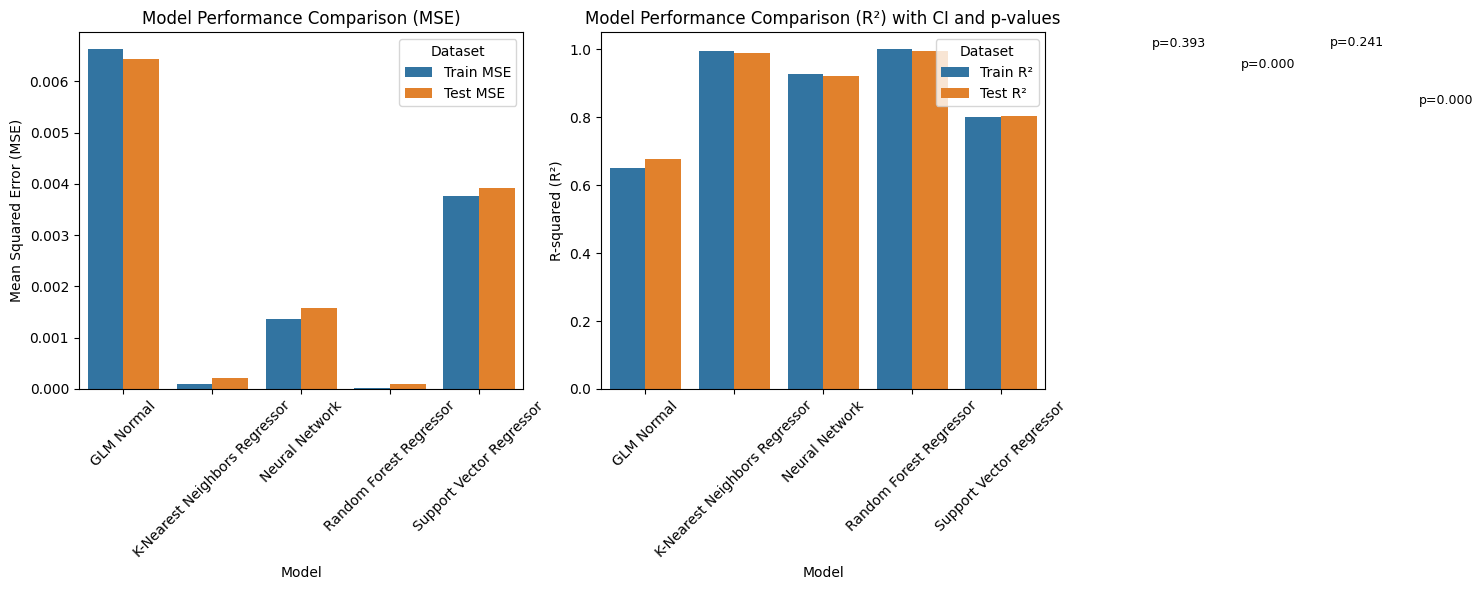

In [97]:
# Convert model results to DataFrame
results_df = pd.DataFrame(model_results)

# Display full evaluation table
print("\nModel Evaluation Results:")
print(results_df)

# Separate metrics
mse_results = results_df[['model', 'mse_train', 'mse_test']].melt(id_vars='model',
    var_name='metric', value_name='score')
r2_results = results_df[['model', 'r2_train', 'r2_test']].melt(id_vars='model',
    var_name='metric', value_name='score')

# Label replacements
mse_results['metric'] = mse_results['metric'].replace({'mse_train': 'Train MSE', 'mse_test': 'Test MSE'})
r2_results['metric'] = r2_results['metric'].replace({'r2_train': 'Train R²', 'r2_test': 'Test R²'})

# Prepare CI and p-value columns for annotating Test R²
r2_results = r2_results.merge(
    results_df[['model', 'r2_test_ci_lower', 'r2_test_ci_upper', 'p_value_vs_ref']],
    on='model', how='left'
)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# === MSE Plot ===
sns.barplot(x='model', y='score', hue='metric', data=mse_results, ax=axes[0])
axes[0].set_title('Model Performance Comparison (MSE)')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Mean Squared Error (MSE)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Dataset')

# === R² Plot ===
for _, row in r2_results[r2_results['metric'] == 'Test R²'].iterrows():
    ci_low = row['r2_test_ci_lower']
    ci_high = row['r2_test_ci_upper']
    model = row['model']
    value = row['score']
    pval = row['p_value_vs_ref']
    xpos = r2_results[(r2_results['model'] == model) & (r2_results['metric'] == 'Test R²')].index[0]

    # Add vertical line for CI
    axes[1].plot([xpos, xpos], [ci_low, ci_high], color='black', lw=1.5)

    # Annotate with p-value
    if pd.notnull(pval):
        axes[1].text(xpos, ci_high + 0.01, f'p={pval:.3f}', ha='center', fontsize=9)

sns.barplot(x='model', y='score', hue='metric', data=r2_results, ax=axes[1])
axes[1].set_title('Model Performance Comparison (R²) with CI and p-values')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R-squared (R²)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Dataset')

plt.tight_layout()
plt.show()
